In [47]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import time

import warnings
warnings.filterwarnings('ignore')

In [48]:
df = pd.read_csv('heart_cleaned.csv')

In [49]:
class FeatureCategorizer:
    def __init__(self, df):
        self.df = df.copy()
        self.continuous_features = []
        self.binary_features = []
        
    def categorize_features(self):
        """Automatically categorize features as continuous or binary"""
        print("Analyzing features...")
        print("="*50)
        
        for col in self.df.columns:
            unique_vals = self.df[col].nunique()
            is_numeric = pd.api.types.is_numeric_dtype(self.df[col])
            unique_values = sorted(self.df[col].unique())
            
            print(f"\n{col}:")
            print(f"  - Unique values: {unique_vals}")
            print(f"  - Is numeric: {is_numeric}")
            print(f"  - Sample values: {unique_values[:5] if len(unique_values) > 5 else unique_values}")
            
            if is_numeric:
                if unique_vals == 2 or set(self.df[col].unique()).issubset({0, 1, 0.0, 1.0}):
                    self.binary_features.append(col)
                    print(f"  → Classified as: BINARY")
                else:
                    self.continuous_features.append(col)
                    print(f"  → Classified as: CONTINUOUS")
            else:
                # Handle boolean or string binary features
                if unique_vals == 2:
                    self.binary_features.append(col)
                    print(f"  → Classified as: BINARY")
                else:
                    print(f"  → Classified as: OTHER (will be ignored)")
        
        print(f"\n{'='*50}")
        print("FINAL CATEGORIZATION:")
        print(f"{'='*50}")
        print(f"Continuous features ({len(self.continuous_features)}): {self.continuous_features}")
        print(f"Binary features ({len(self.binary_features)}): {self.binary_features}")
        
        return self.continuous_features, self.binary_features
    
    def get_feature_stats(self):
        """Get detailed statistics for each feature type"""
        print(f"\n{'='*50}")
        print("FEATURE STATISTICS:")
        print(f"{'='*50}")
        
        if self.continuous_features:
            print("\nCONTINUOUS FEATURES:")
            for feature in self.continuous_features:
                data = self.df[feature]
                print(f"\n{feature}:")
                print(f"  Mean: {data.mean():.2f}")
                print(f"  Std:  {data.std():.2f}")
                print(f"  Min:  {data.min():.2f}")
                print(f"  Max:  {data.max():.2f}")
                print(f"  Q1:   {data.quantile(0.25):.2f}")
                print(f"  Q3:   {data.quantile(0.75):.2f}")
        
        if self.binary_features:
            print("\nBINARY FEATURES:")
            for feature in self.binary_features:
                value_counts = self.df[feature].value_counts()
                print(f"\n{feature}:")
                for val, count in value_counts.items():
                    percentage = (count / len(self.df)) * 100
                    print(f"  {val}: {count} ({percentage:.1f}%)")

In [50]:
# Categorize features
categorizer = FeatureCategorizer(df)
continuous_features, binary_features = categorizer.categorize_features()

# Get detailed statistics
categorizer.get_feature_stats()

Analyzing features...

Age:
  - Unique values: 50
  - Is numeric: True
  - Sample values: [np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32)]
  → Classified as: CONTINUOUS

Sex:
  - Unique values: 2
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(1)]
  → Classified as: BINARY

RestingBP:
  - Unique values: 67
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(80), np.int64(92), np.int64(94), np.int64(95)]
  → Classified as: CONTINUOUS

Cholesterol:
  - Unique values: 222
  - Is numeric: True
  - Sample values: [np.float64(85.0), np.float64(100.0), np.float64(110.0), np.float64(113.0), np.float64(117.0)]
  → Classified as: CONTINUOUS

FastingBS:
  - Unique values: 2
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(1)]
  → Classified as: BINARY

MaxHR:
  - Unique values: 119
  - Is numeric: True
  - Sample values: [np.int64(60), np.int64(63), np.int64(67), np.int64(69), np.int64(70)]
  → Classified as: CONTINUOUS

ExerciseAngina

In [51]:
from sklearn.feature_selection import mutual_info_classif

X = df.drop('HeartDisease', axis=1)
Y = df['HeartDisease']

mutua_informazione_feature = []

def analyze_feature_information(X, Y, continuous_features, binary_features):
    """
    Calcola la mutual information media per feature numeriche e binarie.
    
    Args:
        X (pd.DataFrame): dataset delle feature
        y (pd.Series o array): target
        numerical_features (list): lista nomi delle feature numeriche
        binary_features (list): lista nomi delle feature binarie
    
    Returns:
        dict: valori medi di mutual information
    """
    # Calcolo mutual information per tutte le feature
    mi = mutual_info_classif(X, Y, discrete_features='auto', random_state=42)
    mi_df = pd.DataFrame({
        "feature": X.columns,
        "mutual_info": mi
    })
    
    # Separazione numeriche e binarie
    mi_numerical = mi_df[mi_df["feature"].isin(continuous_features)]["mutual_info"].mean()
    mi_binary = mi_df[mi_df["feature"].isin(binary_features)]["mutual_info"].mean()
    
    return {
        "MI_numerical": mi_numerical,
        "MI_binary": mi_binary
    }

ris = analyze_feature_information(X, Y, continuous_features, binary_features)
print(ris)

{'MI_numerical': np.float64(0.06646737346489448), 'MI_binary': np.float64(0.06725815612608918)}


In [52]:
class ProgressiveOutlierGenerator:
    def __init__(self, df, continuous_features, pre_fitted_scaler=None, pre_fitted_pca=None):
        self.original_df = df.copy()
        self.current_df = df.copy()
        self.continuous_features = continuous_features
        self.contamination_history = []
        self.outlier_indices = set()
        
        # Note: PCA models are no longer needed for univariate-only generation
        # but we keep the parameters for backwards compatibility
        #self.scaler = pre_fitted_scaler
        #self.pca = pre_fitted_pca

        print(f"Initialized with:")
        print(f"  - Dataset size: {len(df)} samples")
        print(f"  - Continuous features: {len(continuous_features)}")
        print(f"  - Mode: Univariate outliers only")

    def add_continuous_outliers(self, contamination_rate=0.02, methods=['extreme'], seed=None):
        rng = np.random.default_rng(seed)
        if not self.continuous_features:
            return {}

        univariate_methods = [m for m in methods if m != 'multivariate']
        if not univariate_methods:
            univariate_methods = ['extreme']

        n_samples = len(self.current_df)
        n_new_outliers = int(round(n_samples * contamination_rate))

        # ensure at least 1 if contamination_rate>0 and there are samples
        if n_new_outliers == 0 and contamination_rate > 0 and n_samples > 0:
            n_new_outliers = 1

        # Use index *labels* (robusto con indici non numerici)
        available_labels = list(set(self.current_df.index) - set(self.outlier_indices))

        if len(available_labels) == 0:
            print("No more clean samples available for contamination.")
            return {}

        if len(available_labels) < n_new_outliers:
            n_new_outliers = len(available_labels)
            print(f"Warning: Only {len(available_labels)} clean samples remaining. Using all of them.")

        # choose labels (object dtype safe)
        chosen = rng.choice(available_labels, size=n_new_outliers, replace=False)

        contamination_info = {}

        # ensure we can revert to original values later
        if not hasattr(self, 'original_values'):
            self.original_values = {}

        for label in chosen:
            method = str(rng.choice(univariate_methods))
            feature = str(rng.choice(self.continuous_features))

            # save original value (first time)
            if label not in self.original_values:
                self.original_values[label] = {}
            if feature not in self.original_values[label]:
                self.original_values[label][feature] = self.current_df.at[label, feature]

            # clean_data: exclude already contaminated *labels*
            clean_labels = [lab for lab in self.current_df.index if lab not in self.outlier_indices]
            clean_data = self.current_df.loc[clean_labels, feature].dropna()
            if clean_data.empty:
                continue

            q1, q3 = clean_data.quantile(0.25), clean_data.quantile(0.75)
            iqr = q3 - q1
            std_val = float(clean_data.std()) if clean_data.std() != 0 else 1.0
            min_val, max_val = clean_data.min(), clean_data.max()

            orig_val = float(self.current_df.at[label, feature])

            if method == 'extreme':
                if rng.random() < 0.5:
                    outlier_val = q1 - rng.uniform(3, 6) * iqr
                    outlier_val = max(outlier_val, float(min_val) - 3 * std_val)
                else:
                    outlier_val = q3 + rng.uniform(3, 6) * iqr
                    outlier_val = min(outlier_val, float(max_val) + 3 * std_val)
            elif method == 'shift':
                shift_factor = rng.choice([-1, 1]) * rng.uniform(2, 4)
                outlier_val = orig_val + shift_factor * std_val
            elif method == 'noise':
                noise_factor = rng.choice([-1, 1]) * rng.uniform(3, 5)
                outlier_val = orig_val + noise_factor * std_val
            else:
                # fallback
                outlier_val = q3 + rng.uniform(3, 6) * iqr

            # domain-aware clipping instead of blind abs
            if feature in ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']:
                lower_bound = 0
                outlier_val = max(outlier_val, lower_bound)

            # preserve integer dtype if necessary
            if pd.api.types.is_integer_dtype(self.current_df[feature].dtype):
                outlier_val = int(round(outlier_val))

            self.current_df.at[label, feature] = outlier_val

            contamination_info.setdefault(feature, []).append({
                'index': label,
                'original_value': self.original_values[label][feature],
                'outlier_value': outlier_val,
                'method': method
            })

        # store labels of contaminated rows
        self.outlier_indices.update(set(chosen))

        return contamination_info


    def progressive_contamination(self, steps=10, max_contamination=1, continuous_methods=['extreme', 'shift']):
        """Progressively contaminate the dataset in steps with univariate outliers only."""
        # Filter out multivariate methods
        univariate_methods = [m for m in continuous_methods if m != 'multivariate']
        if not univariate_methods:
            print("No valid univariate methods provided. Using default methods.")
            univariate_methods = ['extreme', 'shift']
        
        contamination_rates = np.linspace(0, max_contamination, steps + 1)[1:]
        datasets = [self.original_df.copy()]
        
        print("Starting progressive contamination (univariate only)...")
        print(f"Steps: {steps}")
        print(f"Methods: {univariate_methods}")
        print(f"Contamination rates: {[f'{rate:.3f}' for rate in contamination_rates]}")
        
        for step, target_rate in enumerate(contamination_rates, 1):
            print(f"\n--- Step {step}/{steps}: Target contamination {target_rate:.3f} ---")
            
            current_contamination_rate = len(self.outlier_indices) / len(self.current_df)
            incremental_rate = target_rate - current_contamination_rate
            
            if incremental_rate <= 0:
                print("Target contamination already reached or exceeded.")
                datasets.append(self.current_df.copy())
                continue
            
            print(f"Adding univariate outliers (rate: {incremental_rate:.3f})...")
            cont_info = self.add_continuous_outliers(
                contamination_rate=incremental_rate,
                methods=univariate_methods
            )
            
            actual_contamination = len(self.outlier_indices) / len(self.current_df)
            print(f"Actual total contamination: {actual_contamination:.3f}")
            print(f"Total contaminated samples: {len(self.outlier_indices)}")
            
            self.contamination_history.append({
                'step': step,
                'target_rate': target_rate,
                'actual_rate': actual_contamination,
                'contaminated_samples': len(self.outlier_indices),
                'continuous_info': cont_info,
            })
            
            datasets.append(self.current_df.copy())

            res = analyze_feature_information(self.current_df, Y, continuous_features, binary_features)
            res["perc_outliers"] = step / steps
            mutua_informazione_feature.append(res)
        
        return datasets, self.contamination_history

    def get_contamination_summary(self):
        """Print a detailed summary of contamination."""
        print(f"\n{'='*60}")
        print("CONTAMINATION SUMMARY (UNIVARIATE ONLY)")
        print(f"{'='*60}")
        
        print(f"Original dataset size: {len(self.original_df)} samples")
        print(f"Total contaminated samples: {len(self.outlier_indices)}")
        
        for i, history in enumerate(self.contamination_history, 1):
            print(f"\nStep {i}:")
            print(f"  Target rate: {history['target_rate']:.3f}")
            print(f"  Actual rate: {history['actual_rate']:.3f}")
            print(f"  Contaminated samples: {history['contaminated_samples']}")
            
            if history['continuous_info']:
                print("  Univariate outliers by feature:")
                for feature, outliers in history['continuous_info'].items():
                    if outliers:
                        method_counts = {}
                        for outlier in outliers:
                            method = outlier['method']
                            method_counts[method] = method_counts.get(method, 0) + 1
                        
                        method_str = ", ".join([f"{method}: {count}" for method, count in method_counts.items()])
                        print(f"    {feature}: {len(outliers)} new outliers ({method_str})")

    def reset_to_clean(self):
        """Reset to original clean dataset."""
        self.current_df = self.original_df.copy()
        self.outlier_indices = set()
        self.contamination_history = []
        print("Dataset reset to original clean state.")
    
    def get_datasets(self):
        """Return both clean and current contaminated dataset."""
        return self.original_df.copy(), self.current_df.copy()
    
    def debug_outlier_counts(self):
        """Debug function to check outlier counts per feature and method"""
        print("\n" + "="*60)
        print("OUTLIER DEBUG INFORMATION (UNIVARIATE ONLY)")
        print("="*60)
        
        for feature in self.continuous_features:
            method_counts = {}
            
            for history in self.contamination_history:
                if feature in history['continuous_info']:
                    for outlier_info in history['continuous_info'][feature]:
                        method = outlier_info['method']
                        method_counts[method] = method_counts.get(method, 0) + 1
            
            print(f"{feature}:")
            if method_counts:
                for method, count in method_counts.items():
                    print(f"  - {method} outliers: {count}")
                print(f"  - Total outliers: {sum(method_counts.values())}")
            else:
                print(f"  - No outliers")
            print()

In [53]:
loaded_scaler = joblib.load('scaler.joblib')
loaded_pca = joblib.load('pca.joblib')

# Initialize the outlier generator with categorized features
generator = ProgressiveOutlierGenerator(df, continuous_features, pre_fitted_scaler=loaded_scaler, 
    pre_fitted_pca=loaded_pca)

# Generate progressive outliers
datasets, contamination_history = generator.progressive_contamination(
    steps=10,                          
    max_contamination=1,           
    continuous_methods=['extreme', 'shift', 'noise']  
)

# Print detailed summary
generator.get_contamination_summary()

Initialized with:
  - Dataset size: 918 samples
  - Continuous features: 5
  - Mode: Univariate outliers only
Starting progressive contamination (univariate only)...
Steps: 10
Methods: ['extreme', 'shift', 'noise']
Contamination rates: ['0.100', '0.200', '0.300', '0.400', '0.500', '0.600', '0.700', '0.800', '0.900', '1.000']

--- Step 1/10: Target contamination 0.100 ---
Adding univariate outliers (rate: 0.100)...
Actual total contamination: 0.100
Total contaminated samples: 92

--- Step 2/10: Target contamination 0.200 ---
Adding univariate outliers (rate: 0.100)...
Actual total contamination: 0.200
Total contaminated samples: 184

--- Step 3/10: Target contamination 0.300 ---
Adding univariate outliers (rate: 0.100)...
Actual total contamination: 0.300
Total contaminated samples: 275

--- Step 4/10: Target contamination 0.400 ---
Adding univariate outliers (rate: 0.100)...
Actual total contamination: 0.400
Total contaminated samples: 367

--- Step 5/10: Target contamination 0.500 ---

Generating visualizations with only univariate outliers...


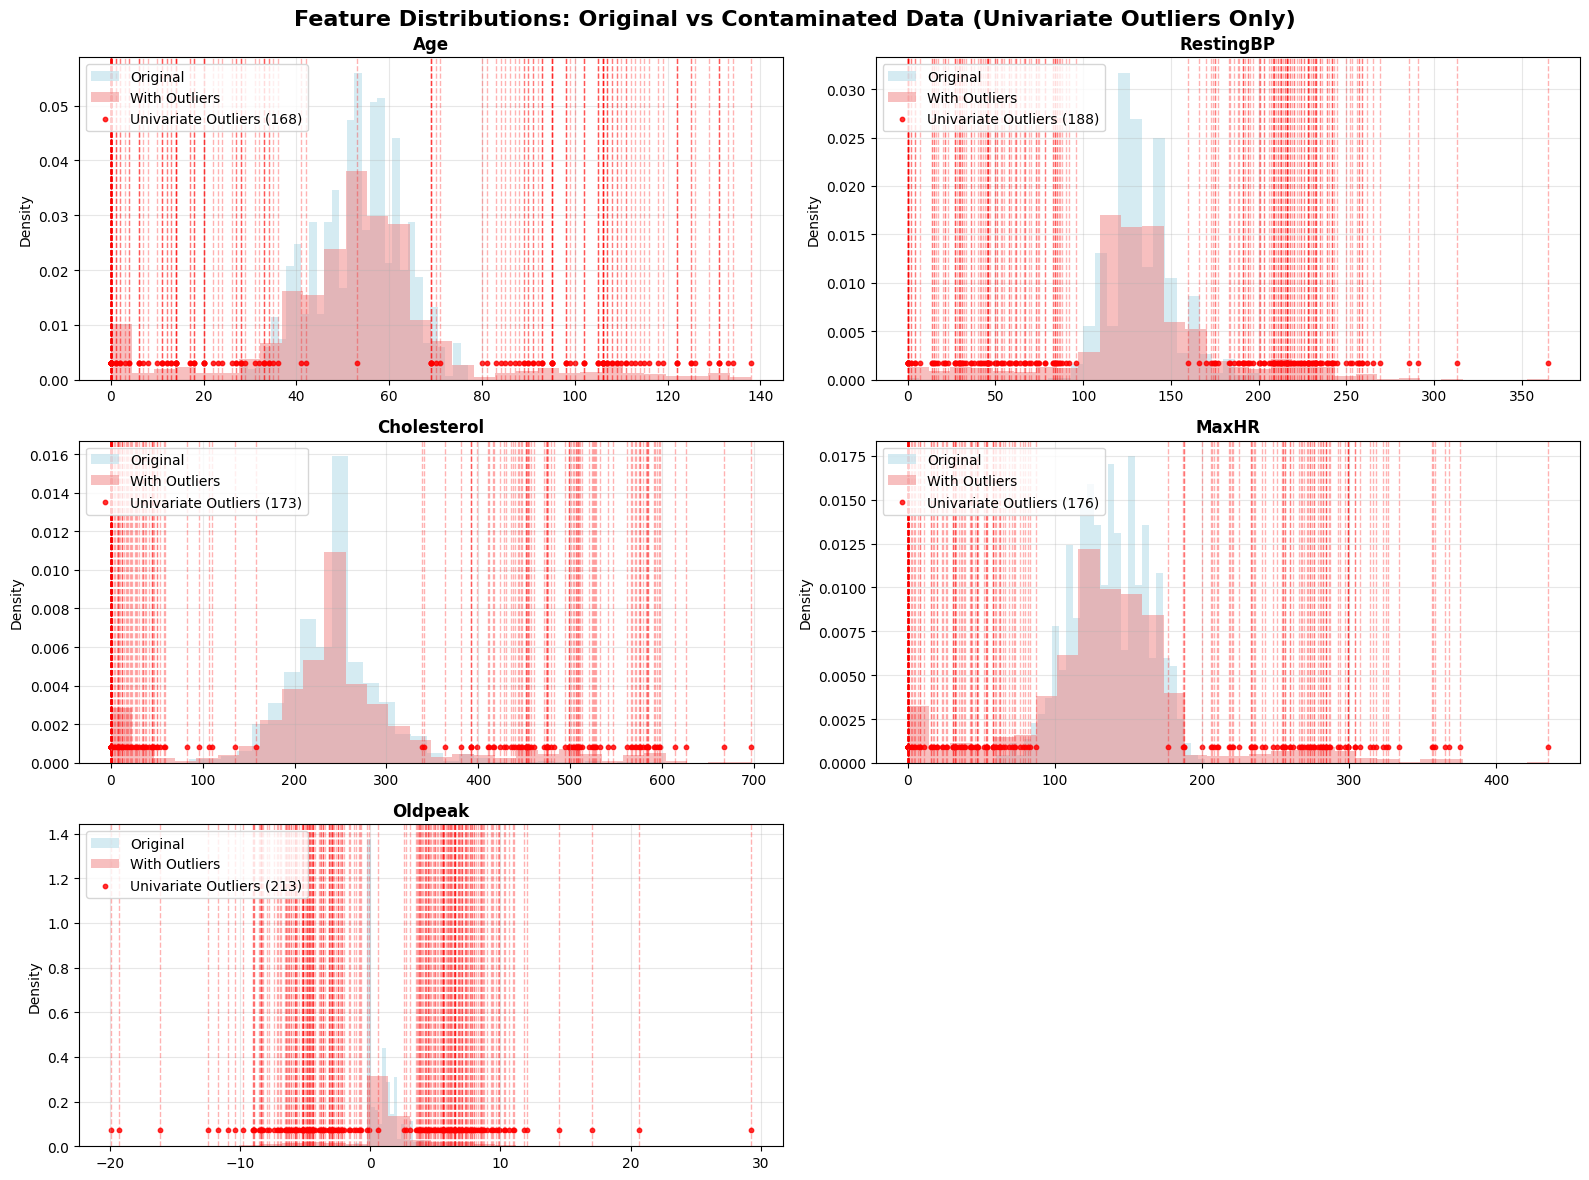

In [54]:
def plot_feature_distributions_with_univariate_outliers(generator, figsize=(16, 12)):
    """
    Plot distributions showing original data vs contaminated data with only univariate outliers highlighted.
    """
    n_features = len(generator.continuous_features)
    
    if n_features == 0:
        print("No features to visualize")
        return
    
    # Calculate grid size
    n_cols = 2
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Handle single row case
    if n_rows == 1:
        if n_cols == 1:
            axes = [axes]
        else:
            axes = axes.reshape(1, -1)
    
    # Flatten axes array for easier indexing
    axes_flat = axes.flatten() if n_features > 1 else [axes]
    
    for i, feature in enumerate(generator.continuous_features):
        ax = axes_flat[i]
        
        # Get original and contaminated data
        original_data = generator.original_df[feature]
        contaminated_data = generator.current_df[feature]
        
        # Plot histograms
        ax.hist(original_data, alpha=0.5, label='Original', bins=30, 
                color='lightblue', density=True)
        ax.hist(contaminated_data, alpha=0.5, label='With Outliers', bins=30, 
                color='lightcoral', density=True)
        
        # --- ONLY UNIVARIATE OUTLIERS ---
        univariate_outliers = []
        for history in generator.contamination_history:
            if feature in history['continuous_info']:
                for outlier_info in history['continuous_info'][feature]:
                    if outlier_info['method'] != 'multivariate':
                        univariate_outliers.append(outlier_info['outlier_value'])
        
        # Plot univariate outliers
        if univariate_outliers:
            y_pos = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05
            ax.scatter(univariate_outliers, [y_pos] * len(univariate_outliers), 
                       color='red', s=10, alpha=0.8, marker='o', 
                       label=f'Univariate Outliers ({len(univariate_outliers)})')
            for val in univariate_outliers:
                ax.axvline(x=val, color='red', linestyle='--', alpha=0.3, linewidth=1)
        
        ax.set_ylabel('Density')
        ax.set_title(f'{feature}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=10, loc='upper left')
        ax.grid(True, alpha=0.3)
    
    # Remove empty subplots
    for j in range(n_features, len(axes_flat)):
        fig.delaxes(axes_flat[j])
    
    plt.suptitle('Feature Distributions: Original vs Contaminated Data (Univariate Outliers Only)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Usage
print("Generating visualizations with only univariate outliers...")
plot_feature_distributions_with_univariate_outliers(generator)

In [55]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import time
from sklearn.inspection import permutation_importance


In [56]:
all_metrics_outliers = []

def calculate_metrics(y_test, y_pred, model_name, approach, step_idx):
    """
    Calculate metrics and return a dictionary with model info
    """
    metrics = {
        'model': model_name,
        'approach': approach,
        'step': step_idx,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }
    
    # Print metrics (to maintain your current output format)
    print(f"Misure di performance globali {model_name.lower()} {approach.lower()}\n")
    print('Accuracy:', metrics['accuracy'])
    print('Precision:', metrics['precision'])
    print('Recall:', metrics['recall'])
    print('F1-score:', metrics['f1_score'])
    
    return metrics

timing_collector_outliers = {
    'dt_naive_training': 0,
    'dt_optimal_training': 0, 
    'dt_hyperparameter': 0,
    'svm_naive_training': 0,
    'svm_optimal_training': 0,
    'svm_hyperparameter': 0,
    'nn_naive_training': 0,
    'nn_optimal_training': 0,
    'nn_hyperparameter': 0
}



DECISION TREE - NAIVE


===== Training Decision Tree (Naive) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Naive): 0.0053 sec
Step 0 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7663043478260869
Precision: 0.8478260869565217
Recall: 0.7289719626168224
F1-score: 0.7839195979899497


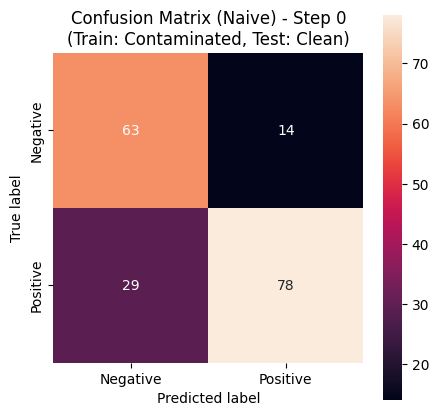

[0.0363838  0.02719666 0.0530965  0.06642373 0.01373097 0.12175758
 0.01510985 0.11918697 0.07745198 0.01053547 0.         0.00710693
 0.         0.01927689 0.00726808 0.         0.00274838 0.42272619]

===== Training Decision Tree (Naive) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 1 | Training time (Naive): 0.0029 sec
Step 1 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.782608695652174
Precision: 0.8383838383838383
Recall: 0.7757009345794392
F1-score: 0.8058252427184466


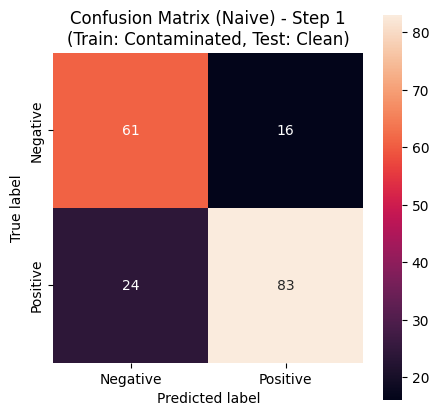

[0.06883604 0.0228658  0.05553641 0.08564032 0.00906019 0.12151339
 0.00408093 0.08541771 0.06988372 0.00471152 0.01569698 0.00655155
 0.00366451 0.00274838 0.0071458  0.01053547 0.00338508 0.42272619]

===== Training Decision Tree (Naive) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 2 | Training time (Naive): 0.0024 sec
Step 2 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8152173913043478
Precision: 0.8613861386138614
Recall: 0.8130841121495327
F1-score: 0.8365384615384616


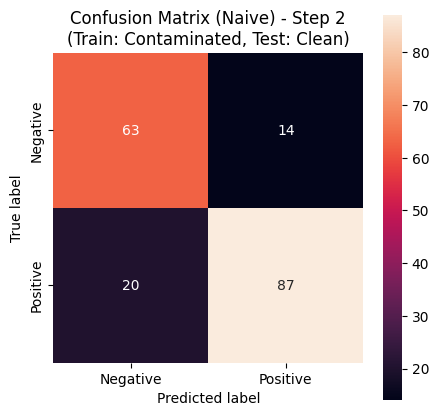

[0.05563031 0.04429214 0.074284   0.08886471 0.00905767 0.08296533
 0.01436695 0.07265183 0.08898086 0.01665172 0.00670684 0.00224429
 0.00400825 0.00471152 0.00496049 0.00063669 0.00626021 0.42272619]

===== Training Decision Tree (Naive) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 3 | Training time (Naive): 0.0023 sec
Step 3 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7717391304347826
Precision: 0.8282828282828283
Recall: 0.7663551401869159
F1-score: 0.7961165048543689


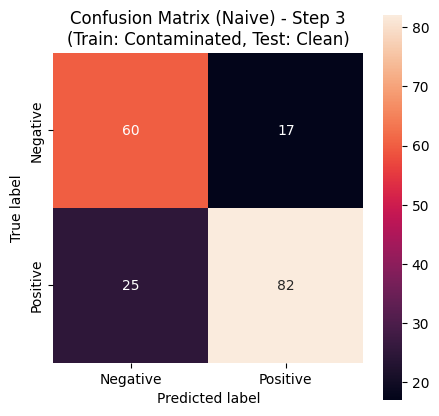

[0.06870369 0.03648456 0.0613495  0.08230386 0.01453363 0.0594515
 0.02415919 0.09316277 0.08898086 0.00471152 0.0135778  0.00224429
 0.00262382 0.00908276 0.0087936  0.00235532 0.00475514 0.42272619]

===== Training Decision Tree (Naive) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 4 | Training time (Naive): 0.0025 sec
Step 4 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8152173913043478
Precision: 0.8762886597938144
Recall: 0.794392523364486
F1-score: 0.8333333333333334


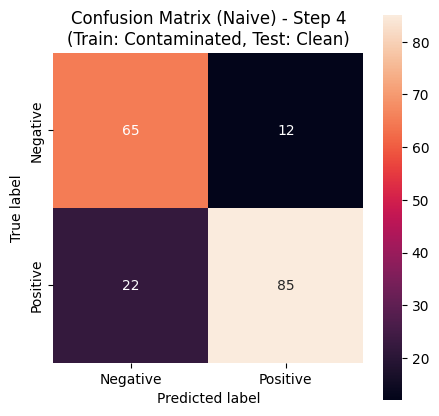

[0.04267181 0.0352427  0.07123373 0.10311804 0.01797021 0.07399236
 0.03045751 0.05268592 0.08898086 0.01254441 0.00439741 0.00227388
 0.01575109 0.01114623 0.00391773 0.         0.01088993 0.42272619]

===== Training Decision Tree (Naive) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 5 | Training time (Naive): 0.0023 sec
Step 5 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.842391304347826
Precision: 0.875
Recall: 0.8504672897196262
F1-score: 0.8625592417061612


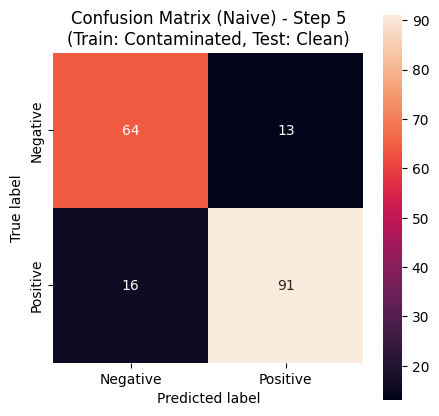

[0.04182615 0.04569013 0.073707   0.09991247 0.01264556 0.05253751
 0.0149577  0.08519284 0.08898086 0.01303226 0.00928026 0.
 0.01588434 0.01092612 0.00093278 0.0006282  0.01113963 0.42272619]

===== Training Decision Tree (Naive) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 6 | Training time (Naive): 0.0027 sec
Step 6 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8043478260869565
Precision: 0.865979381443299
Recall: 0.7850467289719626
F1-score: 0.8235294117647058


[0.06237585 0.03689173 0.08980404 0.04533835 0.01887295 0.0570095
 0.03361203 0.07785368 0.08898086 0.00883409 0.00981566 0.00412258
 0.01182362 0.02199699 0.00137019 0.00794348 0.0006282  0.42272619]

===== Training Decision Tree (Naive) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 7 | Training time (Naive): 0.0029 sec
Step 7 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7880434782608695
Precision: 0.8333333333333334
Recall: 0.794392523364486
F1-score: 0.8133971291866029


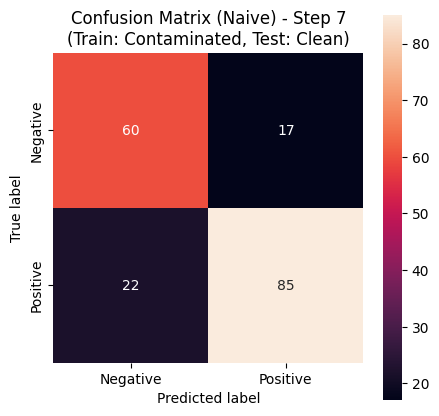

[0.05794545 0.03249432 0.05173103 0.0799485  0.02261463 0.07689256
 0.00785253 0.0984089  0.08898086 0.00753403 0.00488602 0.
 0.02109296 0.02099599 0.0007316  0.         0.00516444 0.42272619]

===== Training Decision Tree (Naive) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 8 | Training time (Naive): 0.0025 sec
Step 8 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7717391304347826
Precision: 0.8217821782178217
Recall: 0.7757009345794392
F1-score: 0.7980769230769231


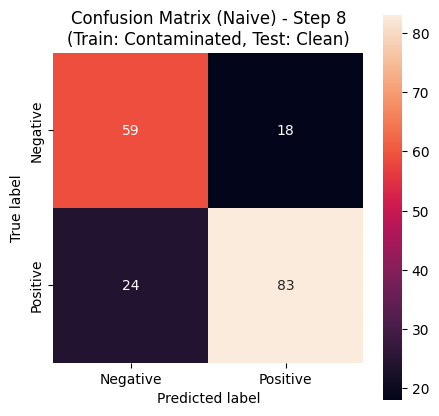

[0.07038843 0.03915707 0.05950589 0.0761472  0.01398693 0.07439135
 0.0240358  0.06187044 0.08898086 0.00753403 0.         0.
 0.01876239 0.02870892 0.00739446 0.00641004 0.         0.42272619]

===== Training Decision Tree (Naive) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 9 | Training time (Naive): 0.0024 sec
Step 9 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8097826086956522
Precision: 0.8333333333333334
Recall: 0.8411214953271028
F1-score: 0.8372093023255814


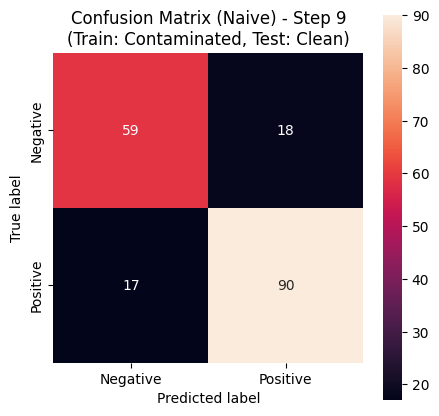

[0.04939224 0.03249432 0.06015674 0.094144   0.02620198 0.0647665
 0.03510881 0.07133383 0.08898086 0.00753403 0.         0.
 0.00167521 0.02759211 0.00847418 0.00075908 0.00865991 0.42272619]

===== Training Decision Tree (Naive) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 10 | Training time (Naive): 0.0026 sec
Step 10 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8206521739130435
Precision: 0.8557692307692307
Recall: 0.8317757009345794
F1-score: 0.8436018957345972


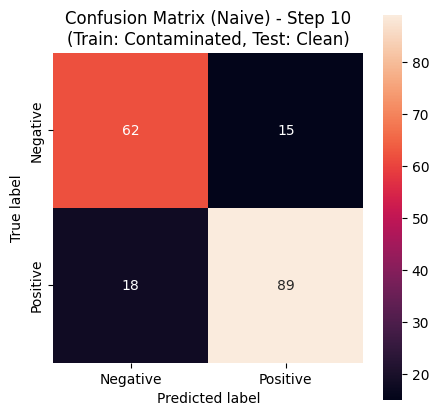

[0.0432985  0.03249432 0.0427762  0.09650723 0.02538764 0.07759039
 0.02953257 0.07681194 0.08898086 0.00753403 0.         0.00390881
 0.0194632  0.01323389 0.01192057 0.         0.00783366 0.42272619]


DECISION TREE - OPTIMIZED


===== Training Decision Tree (Optimized) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Optimized): 0.0018 sec
Step 0 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


[0.         0.05650532 0.         0.         0.         0.
 0.04179656 0.01187573 0.15473143 0.         0.         0.
 0.         0.         0.         0.         0.         0.73509096]

===== Training Decision Tree (Optimized) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 1 | Training time (Optimized): 0.0010 sec
Step 1 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


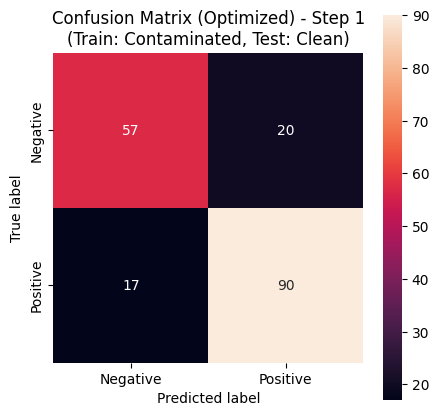

[0.         0.05674302 0.         0.         0.         0.
 0.04197239 0.00771895 0.15538234 0.         0.         0.
 0.         0.         0.         0.         0.         0.7381833 ]

===== Training Decision Tree (Optimized) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 2 | Training time (Optimized): 0.0011 sec
Step 2 | Training Accuracy (Optimized): 0.8665
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


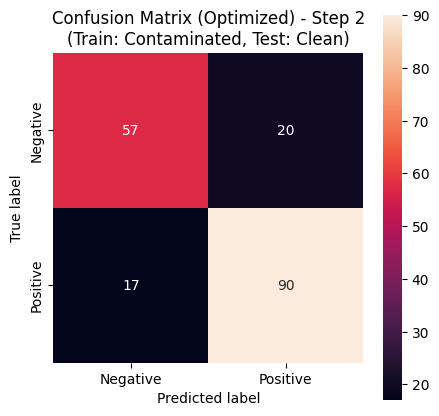

[0.00858956 0.05669324 0.         0.         0.         0.
 0.04193556 0.         0.15524601 0.         0.         0.
 0.         0.         0.         0.         0.         0.73753563]

===== Training Decision Tree (Optimized) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 3 | Training time (Optimized): 0.0013 sec
Step 3 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


[0.         0.05699959 0.         0.         0.         0.
 0.04216216 0.         0.1560849  0.         0.         0.00323235
 0.         0.         0.         0.         0.         0.741521  ]

===== Training Decision Tree (Optimized) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 4 | Training time (Optimized): 0.0009 sec
Step 4 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


[0.         0.05699959 0.         0.         0.         0.
 0.04216216 0.         0.1560849  0.         0.         0.00323235
 0.         0.         0.         0.         0.         0.741521  ]

===== Training Decision Tree (Optimized) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 5 | Training time (Optimized): 0.0053 sec
Step 5 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


[0.         0.05699959 0.         0.         0.         0.
 0.04216216 0.         0.1560849  0.         0.         0.00323235
 0.         0.         0.         0.         0.         0.741521  ]

===== Training Decision Tree (Optimized) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 6 | Training time (Optimized): 0.0011 sec
Step 6 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


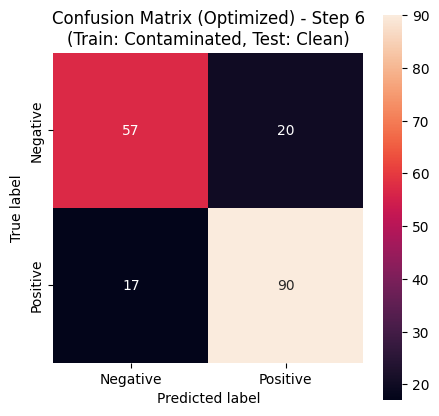

[0.         0.05699959 0.         0.         0.         0.
 0.04216216 0.         0.1560849  0.         0.         0.00323235
 0.         0.         0.         0.         0.         0.741521  ]

===== Training Decision Tree (Optimized) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 7 | Training time (Optimized): 0.0011 sec
Step 7 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


[0.         0.05699959 0.         0.         0.         0.
 0.04216216 0.         0.1560849  0.         0.         0.00323235
 0.         0.         0.         0.         0.         0.741521  ]

===== Training Decision Tree (Optimized) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 8 | Training time (Optimized): 0.0016 sec
Step 8 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


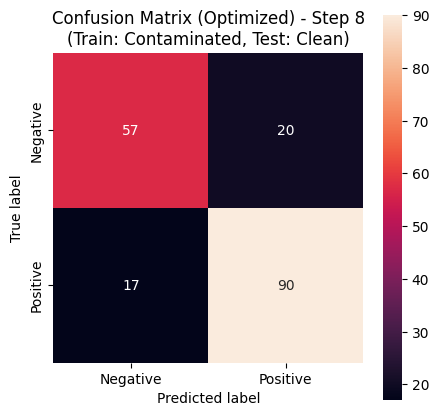

[0.         0.05699959 0.         0.         0.         0.
 0.04216216 0.         0.1560849  0.         0.         0.00323235
 0.         0.         0.         0.         0.         0.741521  ]

===== Training Decision Tree (Optimized) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 9 | Training time (Optimized): 0.0012 sec
Step 9 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


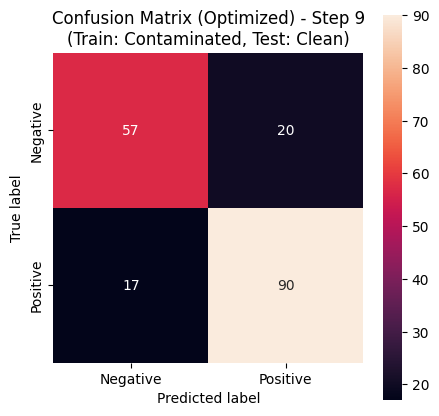

[0.         0.05699959 0.         0.         0.         0.
 0.04216216 0.         0.1560849  0.         0.         0.00323235
 0.         0.         0.         0.         0.         0.741521  ]

===== Training Decision Tree (Optimized) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 10 | Training time (Optimized): 0.0012 sec
Step 10 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


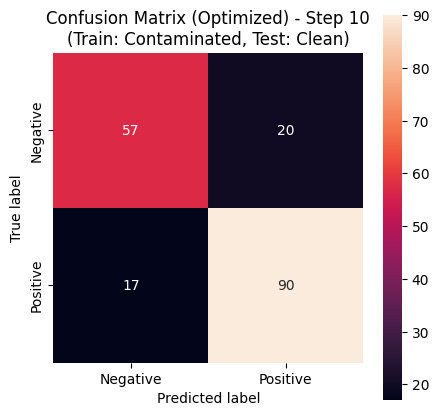

[0.         0.05699959 0.         0.         0.         0.
 0.04216216 0.         0.1560849  0.         0.         0.00323235
 0.         0.         0.         0.         0.         0.741521  ]


SVM - NAIVE


===== Training SVM (Naive) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Naive): 0.0115 sec
Step 0 | Training Accuracy (Naive): 0.7044
Misure di performance globali svm naive

Accuracy: 0.6739130434782609
Precision: 0.7238095238095238
Recall: 0.7102803738317757
F1-score: 0.7169811320754716


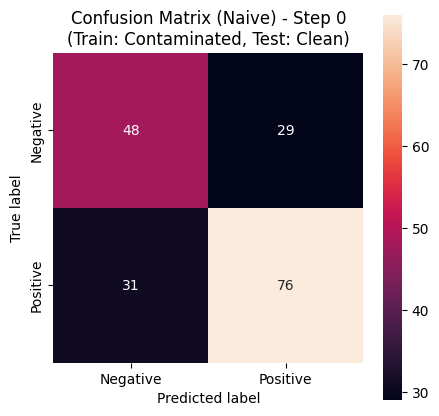


===== Training SVM (Naive) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 1 | Training time (Naive): 0.0086 sec
Step 1 | Training Accuracy (Naive): 0.7057
Misure di performance globali svm naive

Accuracy: 0.6847826086956522
Precision: 0.7333333333333333
Recall: 0.719626168224299
F1-score: 0.7264150943396226


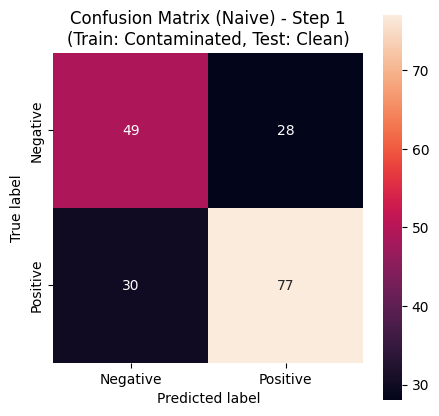


===== Training SVM (Naive) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 2 | Training time (Naive): 0.0084 sec
Step 2 | Training Accuracy (Naive): 0.6826
Misure di performance globali svm naive

Accuracy: 0.6739130434782609
Precision: 0.7079646017699115
Recall: 0.7476635514018691
F1-score: 0.7272727272727273


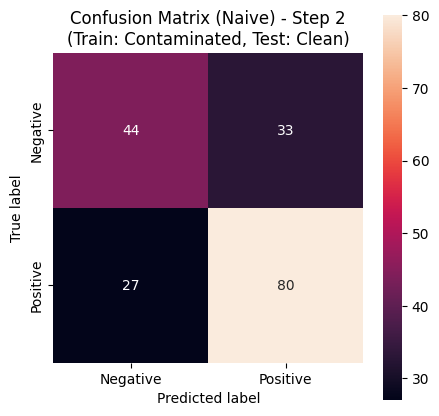


===== Training SVM (Naive) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 3 | Training time (Naive): 0.0085 sec
Step 3 | Training Accuracy (Naive): 0.6608
Misure di performance globali svm naive

Accuracy: 0.7010869565217391
Precision: 0.7
Recall: 0.8504672897196262
F1-score: 0.7679324894514767



===== Training SVM (Naive) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 4 | Training time (Naive): 0.0091 sec
Step 4 | Training Accuracy (Naive): 0.6526
Misure di performance globali svm naive

Accuracy: 0.6793478260869565
Precision: 0.6643835616438356
Recall: 0.9065420560747663
F1-score: 0.766798418972332


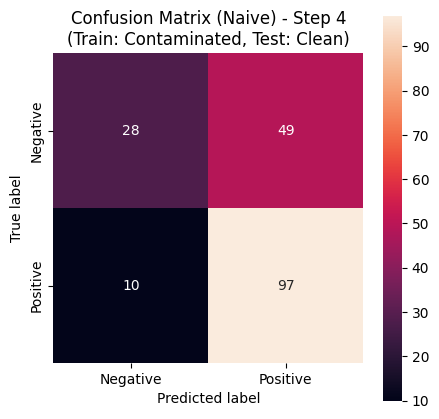


===== Training SVM (Naive) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 5 | Training time (Naive): 0.0249 sec
Step 5 | Training Accuracy (Naive): 0.6362
Misure di performance globali svm naive

Accuracy: 0.6739130434782609
Precision: 0.6577181208053692
Recall: 0.9158878504672897
F1-score: 0.765625



===== Training SVM (Naive) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 6 | Training time (Naive): 0.0087 sec
Step 6 | Training Accuracy (Naive): 0.6240
Misure di performance globali svm naive

Accuracy: 0.6684782608695652
Precision: 0.6455696202531646
Recall: 0.9532710280373832
F1-score: 0.769811320754717


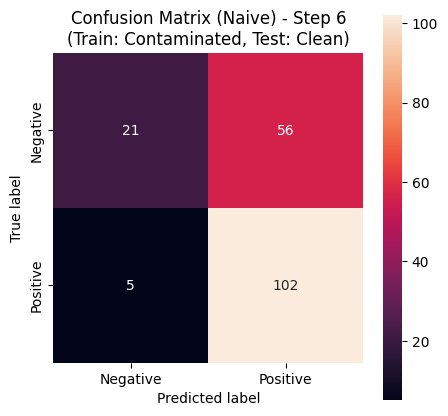


===== Training SVM (Naive) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 7 | Training time (Naive): 0.0090 sec
Step 7 | Training Accuracy (Naive): 0.5940
Misure di performance globali svm naive

Accuracy: 0.6467391304347826
Precision: 0.6235294117647059
Recall: 0.9906542056074766
F1-score: 0.7653429602888087


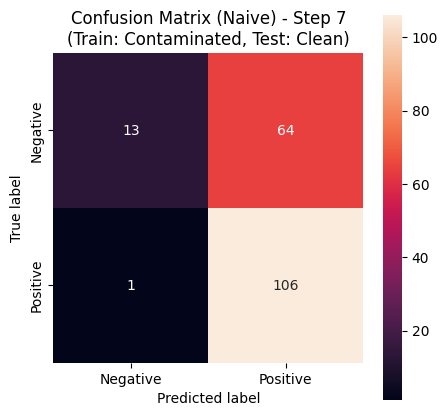


===== Training SVM (Naive) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 8 | Training time (Naive): 0.0092 sec
Step 8 | Training Accuracy (Naive): 0.5913
Misure di performance globali svm naive

Accuracy: 0.6195652173913043
Precision: 0.6045197740112994
Recall: 1.0
F1-score: 0.7535211267605634


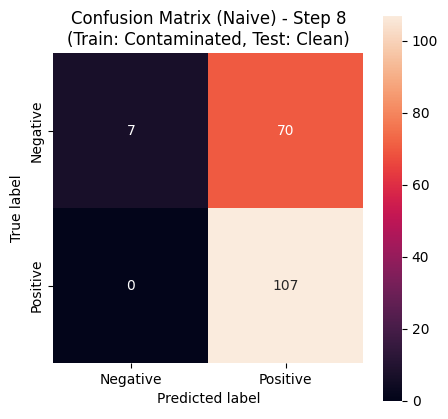


===== Training SVM (Naive) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 9 | Training time (Naive): 0.0090 sec
Step 9 | Training Accuracy (Naive): 0.5899
Misure di performance globali svm naive

Accuracy: 0.6358695652173914
Precision: 0.6149425287356322
Recall: 1.0
F1-score: 0.7615658362989324


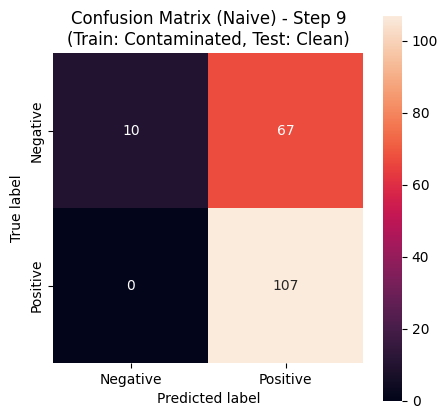


===== Training SVM (Naive) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 10 | Training time (Naive): 0.0091 sec
Step 10 | Training Accuracy (Naive): 0.5886
Misure di performance globali svm naive

Accuracy: 0.625
Precision: 0.6079545454545454
Recall: 1.0
F1-score: 0.7561837455830389




SVM - OPTIMIZED


===== Training SVM (Optimized) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Optimized): 0.0123 sec
Step 0 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.6141304347826086
Precision: 0.652542372881356
Recall: 0.719626168224299
F1-score: 0.6844444444444444


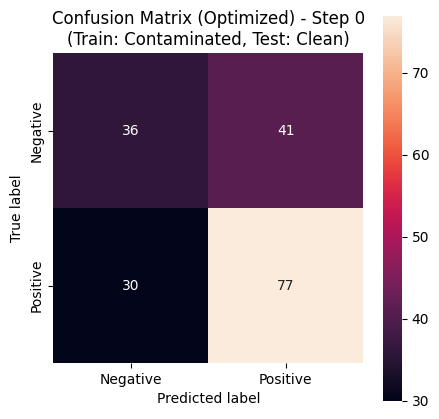


===== Training SVM (Optimized) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 1 | Training time (Optimized): 0.0135 sec
Step 1 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5869565217391305
Precision: 0.6324786324786325
Recall: 0.6915887850467289
F1-score: 0.6607142857142857


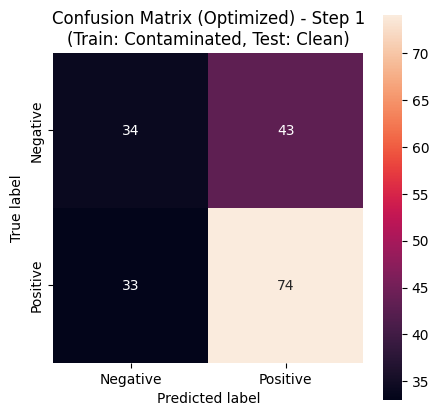


===== Training SVM (Optimized) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 2 | Training time (Optimized): 0.0125 sec
Step 2 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5815217391304348
Precision: 0.6293103448275862
Recall: 0.6822429906542056
F1-score: 0.6547085201793722


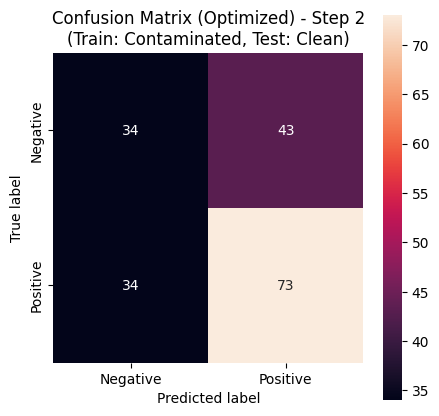


===== Training SVM (Optimized) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 3 | Training time (Optimized): 0.0129 sec
Step 3 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5815217391304348
Precision: 0.6271186440677966
Recall: 0.6915887850467289
F1-score: 0.6577777777777778


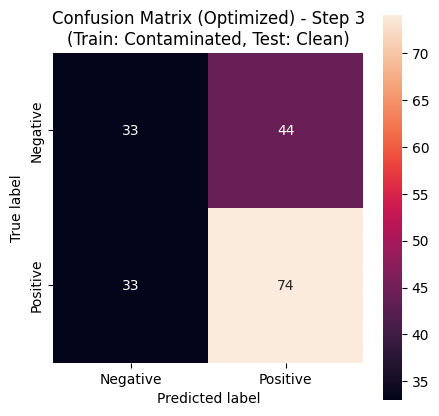


===== Training SVM (Optimized) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 4 | Training time (Optimized): 0.0127 sec
Step 4 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5706521739130435
Precision: 0.6166666666666667
Recall: 0.6915887850467289
F1-score: 0.6519823788546255



===== Training SVM (Optimized) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 5 | Training time (Optimized): 0.0126 sec
Step 5 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.532608695652174
Precision: 0.5853658536585366
Recall: 0.6728971962616822
F1-score: 0.6260869565217392


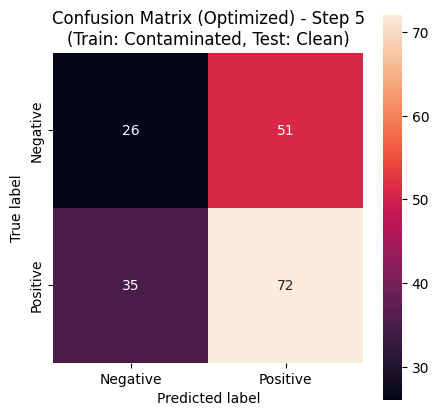


===== Training SVM (Optimized) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 6 | Training time (Optimized): 0.0130 sec
Step 6 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5217391304347826
Precision: 0.5772357723577236
Recall: 0.6635514018691588
F1-score: 0.6173913043478261


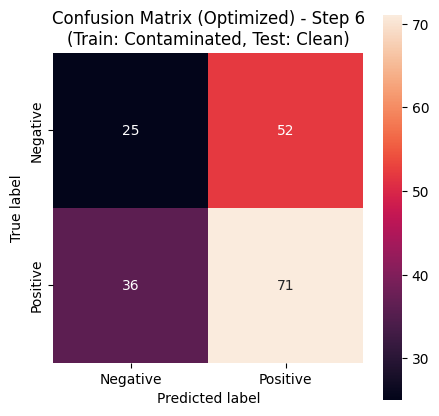


===== Training SVM (Optimized) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 7 | Training time (Optimized): 0.0128 sec
Step 7 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5543478260869565
Precision: 0.6033057851239669
Recall: 0.6822429906542056
F1-score: 0.6403508771929824


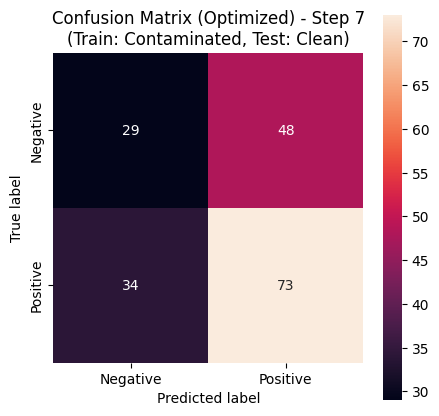


===== Training SVM (Optimized) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 8 | Training time (Optimized): 0.0127 sec
Step 8 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5217391304347826
Precision: 0.576
Recall: 0.6728971962616822
F1-score: 0.6206896551724138


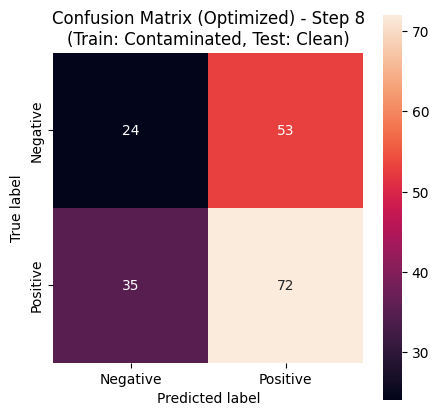


===== Training SVM (Optimized) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 9 | Training time (Optimized): 0.0129 sec
Step 9 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.532608695652174
Precision: 0.5853658536585366
Recall: 0.6728971962616822
F1-score: 0.6260869565217392


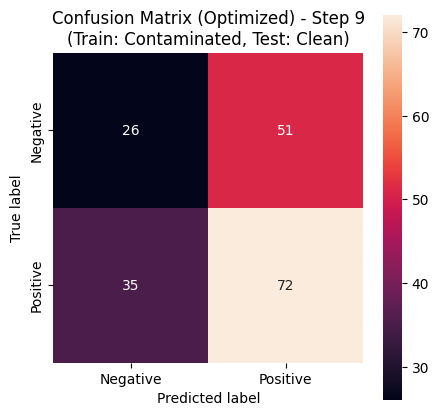


===== Training SVM (Optimized) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 10 | Training time (Optimized): 0.0196 sec
Step 10 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5163043478260869
Precision: 0.5681818181818182
Recall: 0.7009345794392523
F1-score: 0.6276150627615062




NEURAL NETWORK - NAIVE


===== Training Neural Network (Naive) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Naive): 0.1218 sec
Step 0 | Training Accuracy (Naive): 0.8747
Misure di performance globali neural network naive

Accuracy: 0.842391304347826
Precision: 0.8362068965517241
Recall: 0.9065420560747663
F1-score: 0.8699551569506726


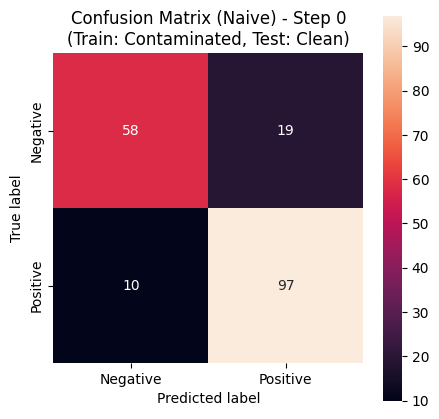


===== Training Neural Network (Naive) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 1 | Training time (Naive): 0.1064 sec
Step 1 | Training Accuracy (Naive): 0.8774
Misure di performance globali neural network naive

Accuracy: 0.8206521739130435
Precision: 0.8245614035087719
Recall: 0.8785046728971962
F1-score: 0.8506787330316742



===== Training Neural Network (Naive) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 2 | Training time (Naive): 0.0966 sec
Step 2 | Training Accuracy (Naive): 0.8801
Misure di performance globali neural network naive

Accuracy: 0.842391304347826
Precision: 0.825
Recall: 0.9252336448598131
F1-score: 0.8722466960352423



===== Training Neural Network (Naive) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 3 | Training time (Naive): 0.1092 sec
Step 3 | Training Accuracy (Naive): 0.8924
Misure di performance globali neural network naive

Accuracy: 0.8315217391304348
Precision: 0.8275862068965517
Recall: 0.897196261682243
F1-score: 0.8609865470852018


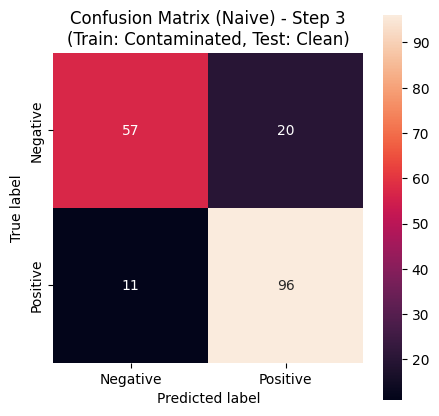


===== Training Neural Network (Naive) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 4 | Training time (Naive): 0.1331 sec
Step 4 | Training Accuracy (Naive): 0.8678
Misure di performance globali neural network naive

Accuracy: 0.8315217391304348
Precision: 0.8064516129032258
Recall: 0.9345794392523364
F1-score: 0.8658008658008658


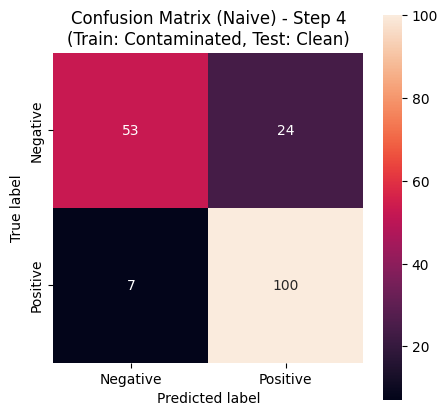


===== Training Neural Network (Naive) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 5 | Training time (Naive): 0.1335 sec
Step 5 | Training Accuracy (Naive): 0.8719
Misure di performance globali neural network naive

Accuracy: 0.8260869565217391
Precision: 0.8048780487804879
Recall: 0.9252336448598131
F1-score: 0.8608695652173913


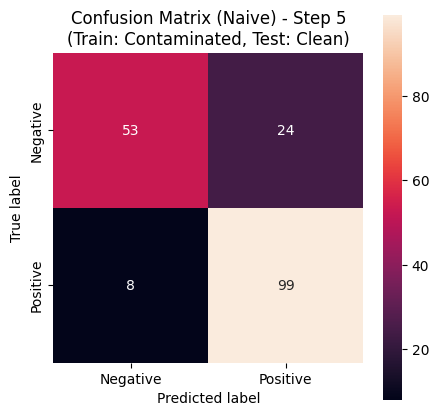


===== Training Neural Network (Naive) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 6 | Training time (Naive): 0.1291 sec
Step 6 | Training Accuracy (Naive): 0.8801
Misure di performance globali neural network naive

Accuracy: 0.8315217391304348
Precision: 0.8114754098360656
Recall: 0.9252336448598131
F1-score: 0.8646288209606987


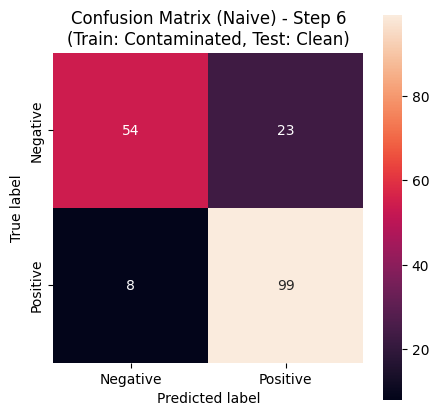


===== Training Neural Network (Naive) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 7 | Training time (Naive): 0.1458 sec
Step 7 | Training Accuracy (Naive): 0.8896
Misure di performance globali neural network naive

Accuracy: 0.8260869565217391
Precision: 0.8151260504201681
Recall: 0.9065420560747663
F1-score: 0.8584070796460177


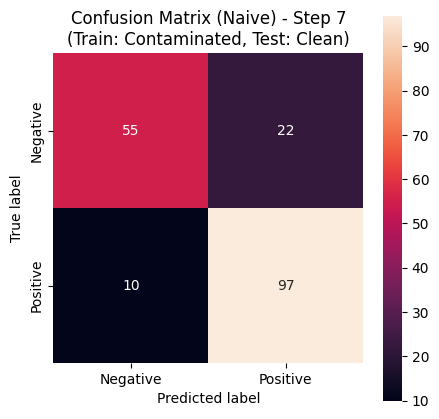


===== Training Neural Network (Naive) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 8 | Training time (Naive): 0.1385 sec
Step 8 | Training Accuracy (Naive): 0.8951
Misure di performance globali neural network naive

Accuracy: 0.8152173913043478
Precision: 0.811965811965812
Recall: 0.8878504672897196
F1-score: 0.8482142857142857



===== Training Neural Network (Naive) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 9 | Training time (Naive): 0.1419 sec
Step 9 | Training Accuracy (Naive): 0.8937
Misure di performance globali neural network naive

Accuracy: 0.8043478260869565
Precision: 0.808695652173913
Recall: 0.8691588785046729
F1-score: 0.8378378378378378


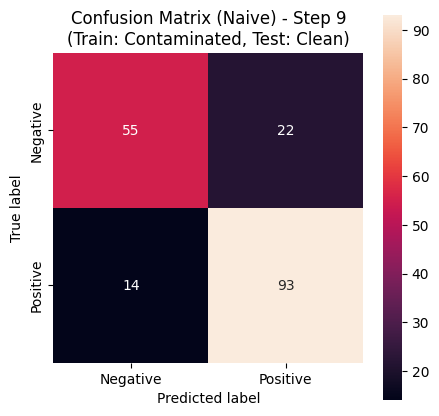


===== Training Neural Network (Naive) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 10 | Training time (Naive): 0.1707 sec
Step 10 | Training Accuracy (Naive): 0.9074
Misure di performance globali neural network naive

Accuracy: 0.7934782608695652
Precision: 0.822429906542056
Recall: 0.822429906542056
F1-score: 0.822429906542056




NEURAL NETWORK - OPTIMIZED


===== Training Neural Network (Optimized) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Optimized): 0.1087 sec
Step 0 | Training Accuracy (Optimized): 0.8747
Misure di performance globali neural network optimized

Accuracy: 0.842391304347826
Precision: 0.8362068965517241
Recall: 0.9065420560747663
F1-score: 0.8699551569506726



===== Training Neural Network (Optimized) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 1 | Training time (Optimized): 0.1129 sec
Step 1 | Training Accuracy (Optimized): 0.8774
Misure di performance globali neural network optimized

Accuracy: 0.8206521739130435
Precision: 0.8245614035087719
Recall: 0.8785046728971962
F1-score: 0.8506787330316742


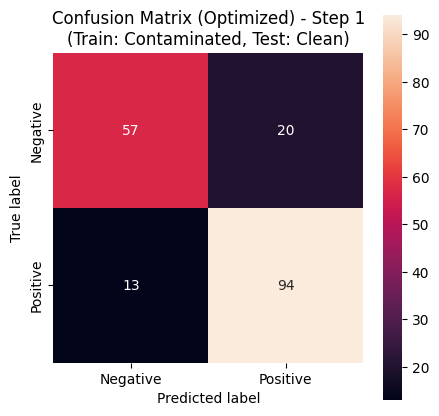


===== Training Neural Network (Optimized) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 2 | Training time (Optimized): 0.1503 sec
Step 2 | Training Accuracy (Optimized): 0.8801
Misure di performance globali neural network optimized

Accuracy: 0.842391304347826
Precision: 0.825
Recall: 0.9252336448598131
F1-score: 0.8722466960352423


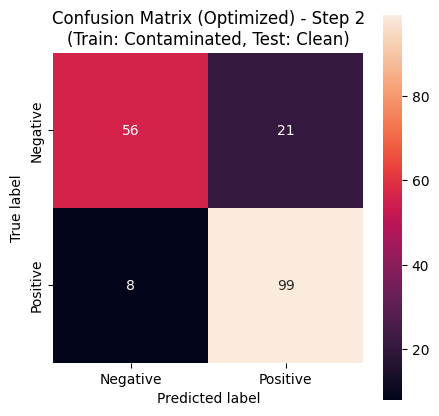


===== Training Neural Network (Optimized) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 3 | Training time (Optimized): 0.1099 sec
Step 3 | Training Accuracy (Optimized): 0.8924
Misure di performance globali neural network optimized

Accuracy: 0.8315217391304348
Precision: 0.8275862068965517
Recall: 0.897196261682243
F1-score: 0.8609865470852018


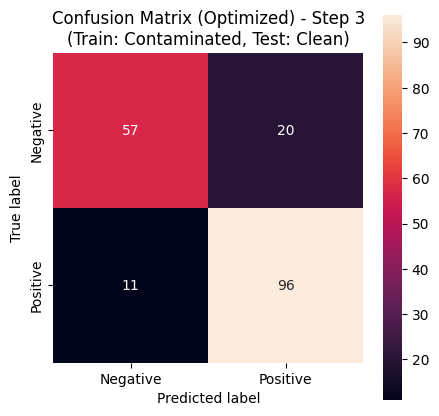


===== Training Neural Network (Optimized) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 4 | Training time (Optimized): 0.1360 sec
Step 4 | Training Accuracy (Optimized): 0.8678
Misure di performance globali neural network optimized

Accuracy: 0.8315217391304348
Precision: 0.8064516129032258
Recall: 0.9345794392523364
F1-score: 0.8658008658008658



===== Training Neural Network (Optimized) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 5 | Training time (Optimized): 0.1368 sec
Step 5 | Training Accuracy (Optimized): 0.8719
Misure di performance globali neural network optimized

Accuracy: 0.8260869565217391
Precision: 0.8048780487804879
Recall: 0.9252336448598131
F1-score: 0.8608695652173913


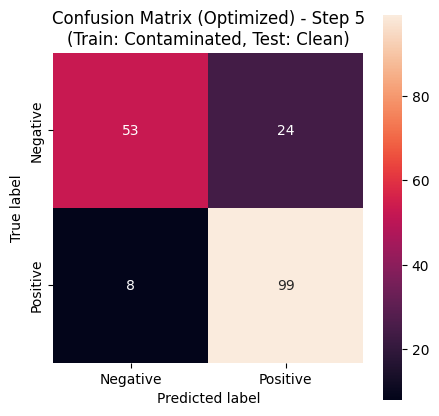


===== Training Neural Network (Optimized) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 6 | Training time (Optimized): 0.1436 sec
Step 6 | Training Accuracy (Optimized): 0.8801
Misure di performance globali neural network optimized

Accuracy: 0.8315217391304348
Precision: 0.8114754098360656
Recall: 0.9252336448598131
F1-score: 0.8646288209606987



===== Training Neural Network (Optimized) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 7 | Training time (Optimized): 0.1365 sec
Step 7 | Training Accuracy (Optimized): 0.8896
Misure di performance globali neural network optimized

Accuracy: 0.8260869565217391
Precision: 0.8151260504201681
Recall: 0.9065420560747663
F1-score: 0.8584070796460177


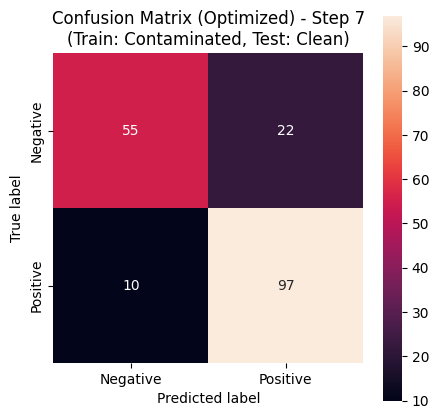


===== Training Neural Network (Optimized) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 8 | Training time (Optimized): 0.1442 sec
Step 8 | Training Accuracy (Optimized): 0.8951
Misure di performance globali neural network optimized

Accuracy: 0.8152173913043478
Precision: 0.811965811965812
Recall: 0.8878504672897196
F1-score: 0.8482142857142857


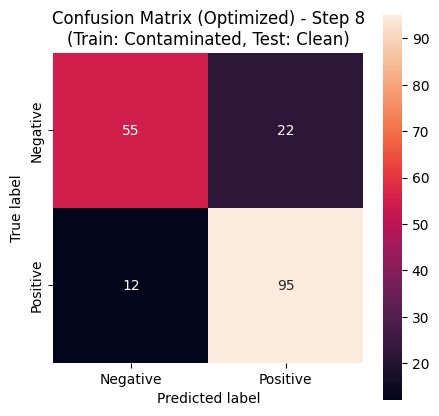


===== Training Neural Network (Optimized) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 9 | Training time (Optimized): 0.1422 sec
Step 9 | Training Accuracy (Optimized): 0.8937
Misure di performance globali neural network optimized

Accuracy: 0.8043478260869565
Precision: 0.808695652173913
Recall: 0.8691588785046729
F1-score: 0.8378378378378378


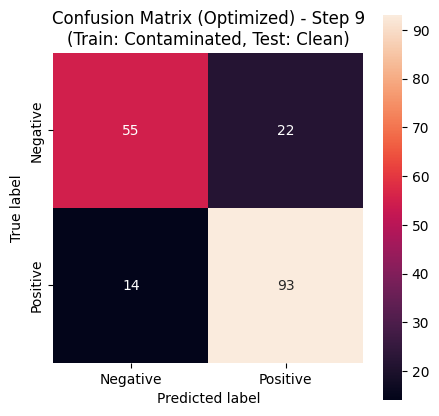


===== Training Neural Network (Optimized) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Contaminated samples in training set: 734
Step 10 | Training time (Optimized): 0.2271 sec
Step 10 | Training Accuracy (Optimized): 0.9074
Misure di performance globali neural network optimized

Accuracy: 0.7934782608695652
Precision: 0.822429906542056
Recall: 0.822429906542056
F1-score: 0.822429906542056


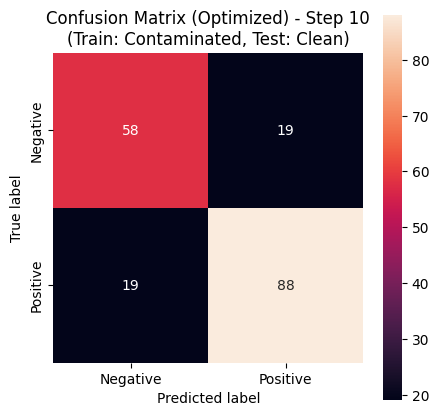

In [57]:
#import shap


best_dt = best_dt = joblib.load('best_decision_tree_model.pkl')
best_svm = joblib.load('best_svm_model.pkl')
best_nn = joblib.load('best_nn_model.pkl')
best_nn_params = {
    'activation': best_nn.get('model__activation', 'relu'),
    'hidden_layer_sizes': best_nn.get('model__hidden_layer_sizes', (100,)),
    'random_state': 42,
    'max_iter': 1000
}

X_original = df.drop('HeartDisease', axis=1)  # df è il dataset originale pulito
y_original = df['HeartDisease']

# Split del dataset originale per ottenere il test set pulito
X_temp, X_test_clean, y_temp, y_test_clean = train_test_split(
    X_original, y_original, test_size=0.2, random_state=0
)

feature_importances = {}

confusion_matrix_values = {}

def train_and_evaluate_model(datasets, X_test_clean, y_test_clean, 
                             model_class, model_params, model_name, 
                             approach_name, timing_collector, 
                             all_metrics_list, generator=None,
                             optimized_params=None):
    """
    Funzione generica per addestrare e valutare modelli su dataset contaminati
    
    Parameters:
    -----------
    datasets : list
        Lista dei dataset contaminati per ogni step
    X_test_clean, y_test_clean : array-like
        Test set pulito (costante per tutti gli step)
    model_class : class
        Classe del modello (es. DecisionTreeClassifier, SVC, MLPClassifier)
    model_params : dict
        Parametri base del modello
    model_name : str
        Nome del modello per le metriche
    approach_name : str
        Nome dell'approccio (es. 'Naive', 'Optimized')
    timing_collector : dict
        Dizionario per raccogliere i tempi di training
    all_metrics_list : list
        Lista per raccogliere tutte le metriche
    generator : object, optional
        Generatore di outlier per contare campioni contaminati
    optimized_params : dict, optional
        Parametri ottimizzati (se diversi da model_params)
    """
    
    # Usa parametri ottimizzati se forniti, altrimenti usa quelli base
    final_params = optimized_params if optimized_params is not None else model_params
    
    print(f"\n\n======================")
    print(f"{model_name.upper()} - {approach_name.upper()}")
    print(f"======================\n")

    # Crea la chiave per questo modello e approccio
    cm_key = f"{model_name} - {approach_name}"
    if cm_key not in confusion_matrix_values:
        confusion_matrix_values[cm_key] = {}
    
    for step_idx, contaminated_df in enumerate(datasets):
        print(f"\n===== Training {model_name} ({approach_name}) at Step {step_idx} =====")
        
        # Prepara dati dal dataset contaminato per il TRAINING
        X_contaminated = contaminated_df.drop('HeartDisease', axis=1)
        y_contaminated = contaminated_df['HeartDisease']
        
        # Split del dataset contaminato SOLO per ottenere il training set
        X_train_contaminated, _, y_train_contaminated, _ = train_test_split(
            X_contaminated, y_contaminated, test_size=0.2, random_state=0
        )
        
        # Training su dati contaminati, test su dati puliti
        X_train = X_train_contaminated
        y_train = y_train_contaminated
        X_test = X_test_clean
        y_test = y_test_clean
        
        print(f"Training set size: {len(X_train)} samples (contaminated)")
        print(f"Test set size: {len(X_test)} samples (clean)")
        
        # Conta campioni contaminati nel training set (solo se disponibile)
        if step_idx > 0 and generator is not None:
            contaminated_training_samples = len(set(X_train.index) & generator.outlier_indices)
            print(f"Contaminated samples in training set: {contaminated_training_samples}")
        
        # Crea e addestra il modello
        model = model_class(**final_params)
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        
        training_time = end_time - start_time
        print(f"Step {step_idx} | Training time ({approach_name}): {training_time:.4f} sec")
        
        # Salva il tempo nel dizionario
        timing_key = f"{model_name.lower().replace(' ', '_')}_{approach_name.lower()}_training_step_{step_idx}"
        timing_collector[timing_key] = training_time
        
        # Accuracy sul training (contaminato)
        accuracy_train = model.score(X_train, y_train)
        print(f"Step {step_idx} | Training Accuracy ({approach_name}): {accuracy_train:.4f}")
        
        # Predizioni sul test set PULITO
        y_pred = model.predict(X_test)
        
        # Calcolo metriche
        metrics = calculate_metrics(y_test, y_pred, model_name, approach_name, step_idx)
        metrics['training_time'] = training_time
        metrics['train_accuracy'] = accuracy_train
        metrics['contamination_step'] = step_idx
        metrics['test_set_type'] = 'clean'
        
        # Aggiungi alle metriche globali
        all_metrics_list.append(metrics)
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        TN, FP, FN, TP = cm.ravel()
        # Salva i valori nella struttura dati
        confusion_matrix_values[cm_key][step_idx] = {
            'TN': int(TN),  # True Negative
            'FP': int(FP),  # False Positive  
            'FN': int(FN),  # False Negative
            'TP': int(TP),  # True Positive
            'confusion_matrix': cm.tolist()  # Salva anche la matrice completa
        }

        plt.figure(figsize=(5,5))
        sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.title(f"Confusion Matrix ({approach_name}) - Step {step_idx}\n(Train: Contaminated, Test: Clean)")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

        # Salvataggio feature importances per Decision Tree
        key = f"{model_name} - {approach_name}"
        if model_name == 'Decision Tree':
            print(model.feature_importances_)
            if key not in feature_importances:
                feature_importances[key] = {}
            feature_importances[key][step_idx] = model.feature_importances_
        '''
        # Salvataggio feature importances per SVM tramite SHAP
        if model_name == 'SVM':
            background = shap.sample(X_train, 20)  # Usa un piccolo campione per velocità
            explainer = shap.KernelExplainer(model.predict, background)
            shap_values = explainer.shap_values(X_train, nsamples=20)  # Limita nsamples per velocità
            mean_abs_shap = np.abs(shap_values).mean(axis=0)
            print("SHAP feature importances (SVM):", mean_abs_shap)
            if key not in feature_importances:
                feature_importances[key] = {}
            feature_importances[key][step_idx] = mean_abs_shap
        '''



train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=DecisionTreeClassifier,
        model_params={},  # Usa i parametri di default
        model_name='Decision Tree',
        approach_name='Naive',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator)

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=DecisionTreeClassifier,
        model_params=best_dt, 
        model_name='Decision Tree',
        approach_name='Optimized',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator)

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=svm.SVC,
        model_params={},  # Usa i parametri di default
        model_name='SVM',
        approach_name='Naive',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator)

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=svm.SVC,
        model_params=best_svm, 
        model_name='SVM',
        approach_name='Optimized',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator)

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=MLPClassifier,
        model_params={'random_state': 42, 'max_iter': 1000}, 
        model_name='Neural Network',
        approach_name='Naive',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator)

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=MLPClassifier,
        model_params=best_nn_params,
        model_name='Neural Network',
        approach_name='Optimized',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator)

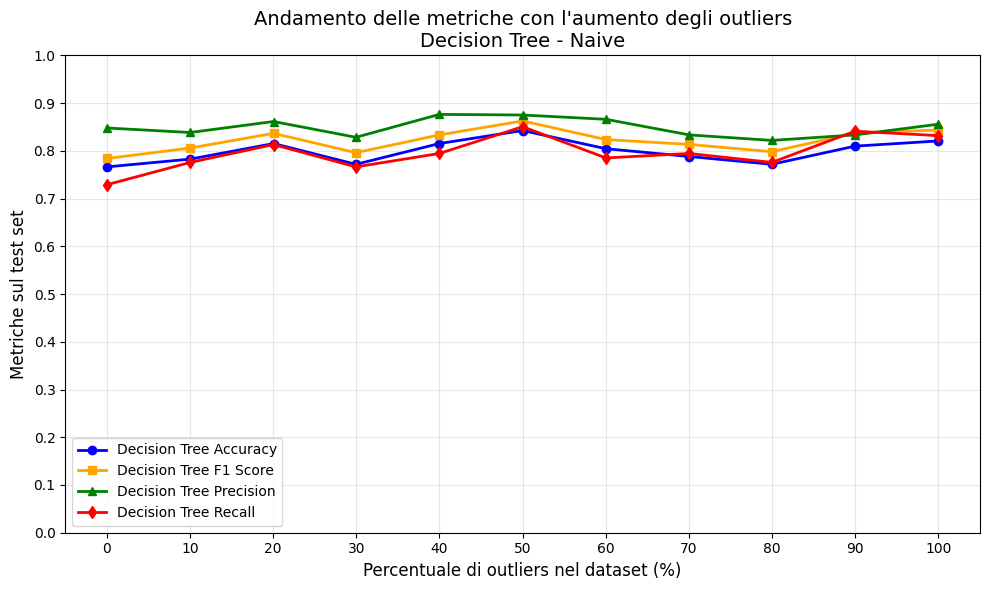

<Figure size 640x480 with 0 Axes>

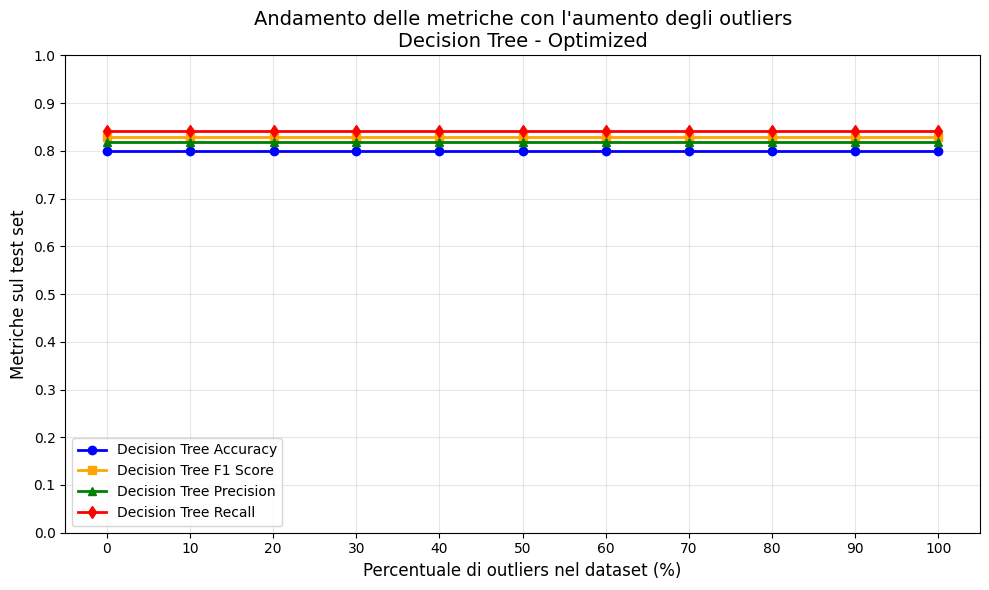

<Figure size 640x480 with 0 Axes>

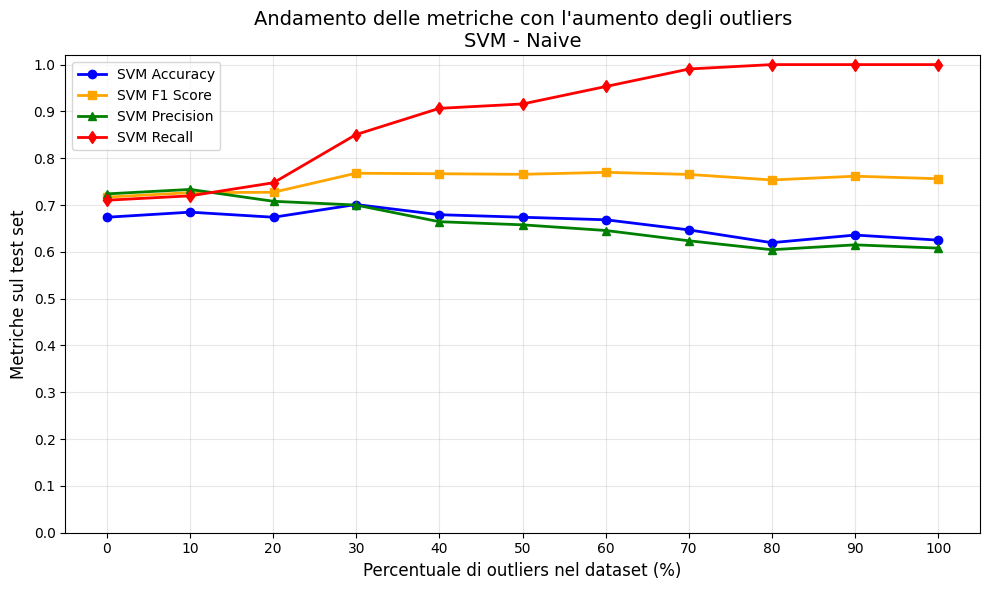

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

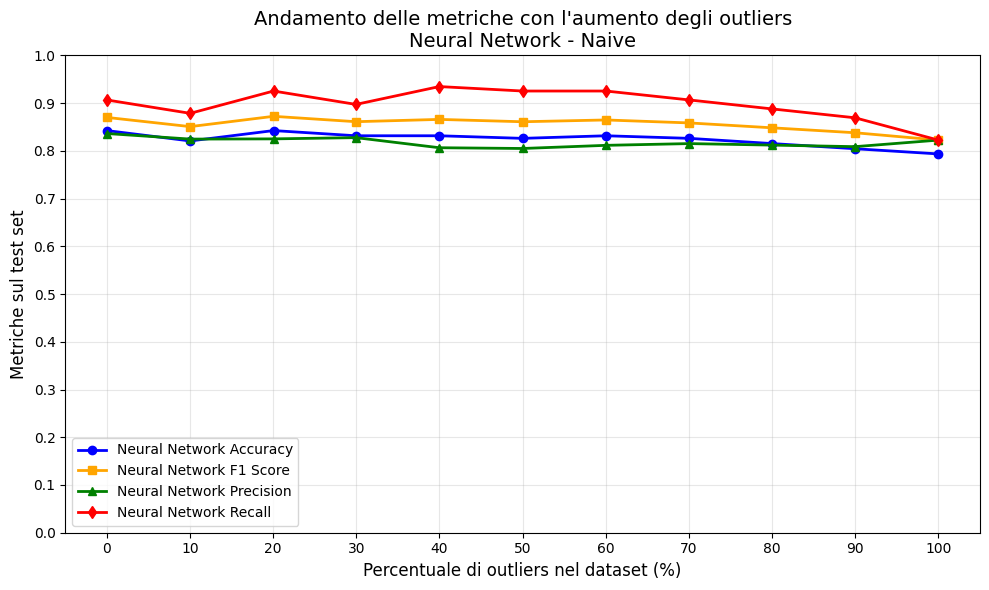

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

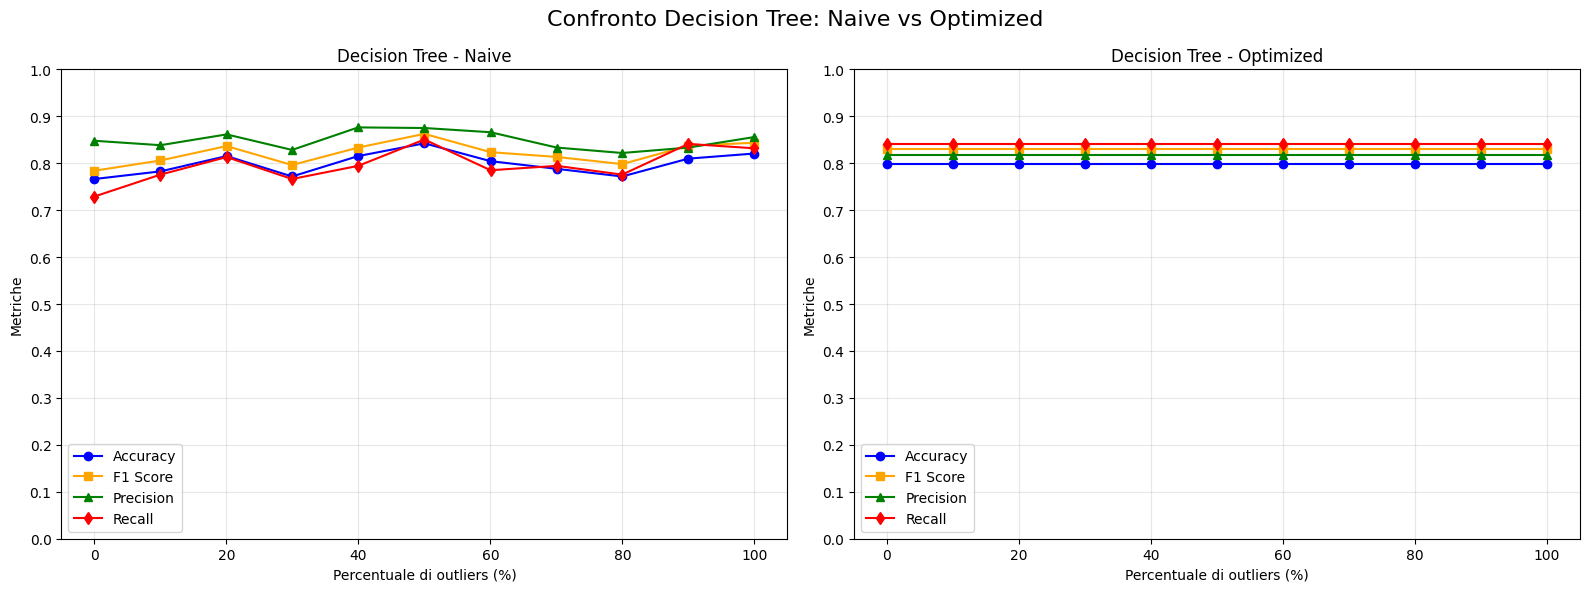

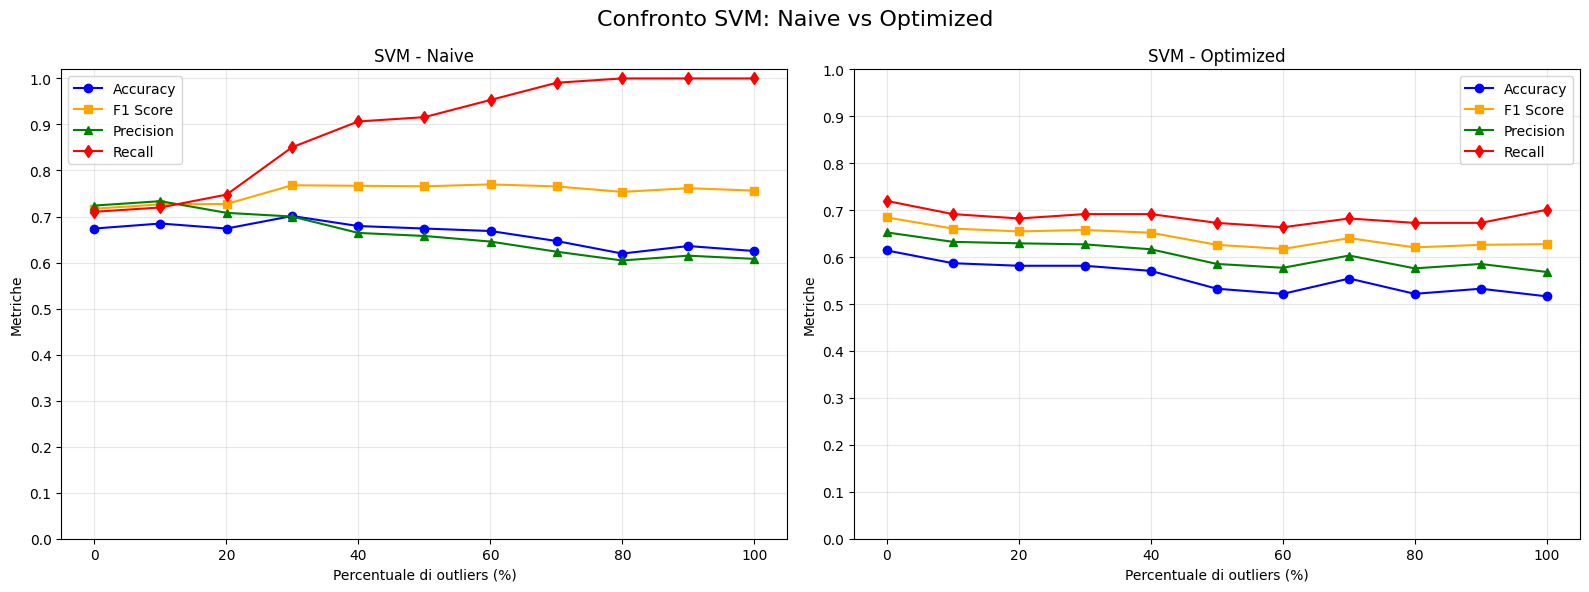

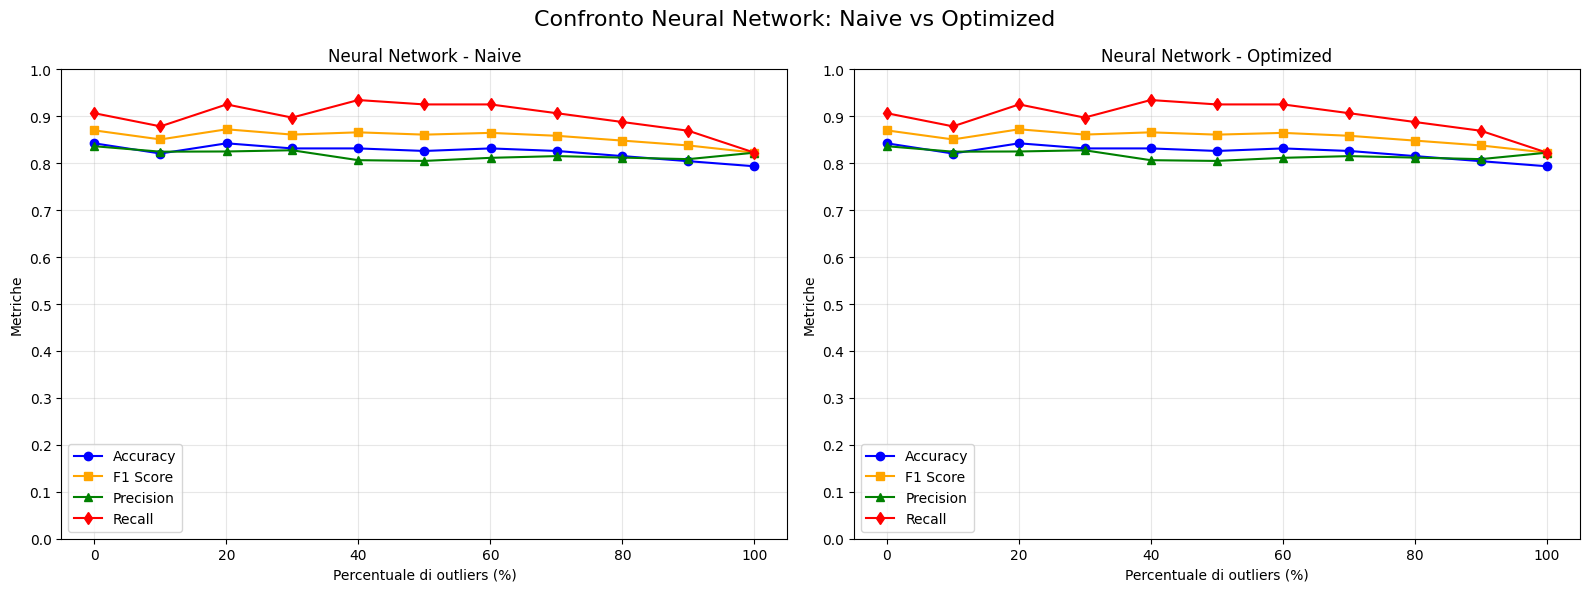

In [58]:
def plot_model_metrics_vs_contamination(all_metrics_outliers, contamination_history, 
                                        model_name, approach='Optimized', 
                                        figsize=(10, 6), save_path=None):
    """
    Crea un grafico delle metriche vs percentuale di contaminazione per un modello specifico
    
    Parameters:
    -----------
    all_metrics_outliers : list
        Lista con tutte le metriche raccolte
    contamination_history : list
        Storia della contaminazione con step e actual_rate
    model_name : str
        Nome del modello da plottare (es. 'Decision Tree', 'SVM', 'Neural Network')
    approach : str, default 'Optimized'
        Approccio da visualizzare ('Naive' o 'Optimized')
    figsize : tuple, default (10, 6)
        Dimensione della figura
    save_path : str, optional
        Path per salvare il grafico (se None, non salva)
    
    Returns:
    --------
    plt.Figure : La figura matplotlib creata
    """
    
    # Creo DataFrame da contamination_history
    contam_df = pd.DataFrame([
        {"step": h['step'], "contamination_rate": h['actual_rate']}
        for h in contamination_history
    ])
    
    # Aggiungo il caso iniziale (0% outliers) se non presente
    if 0 not in contam_df["step"].values:
        contam_df = pd.concat([
            pd.DataFrame([{"step": 0, "contamination_rate": 0.0}]),
            contam_df
        ], ignore_index=True)
    
    # Creo DataFrame delle metriche
    metrics_df = pd.DataFrame(all_metrics_outliers)
    
    # Merge su 'step'
    merged_df = pd.merge(metrics_df, contam_df, on="step", how="left")
    
    # Ordino i valori per contamination_rate
    merged_df = merged_df.sort_values("contamination_rate")
    
    # Filtro per il modello e approccio specifici
    filtered_df = merged_df[
        (merged_df["approach"] == approach) & 
        (merged_df["model"] == model_name)
    ]
    
    # Verifica che ci siano dati da plottare
    if filtered_df.empty:
        print(f"Nessun dato trovato per {model_name} - {approach}")
        return None
    
    # Crea il grafico
    plt.figure(figsize=figsize)
    
    # Plot delle metriche
    plt.plot(filtered_df["contamination_rate"]*100, filtered_df["accuracy"], 
             marker='o', color='blue', linewidth=2, markersize=6, label=f"{model_name} Accuracy")
    plt.plot(filtered_df["contamination_rate"]*100, filtered_df["f1_score"], 
             marker='s', color='orange', linewidth=2, markersize=6, label=f"{model_name} F1 Score")
    plt.plot(filtered_df["contamination_rate"]*100, filtered_df["precision"], 
             marker='^', color='green', linewidth=2, markersize=6, label=f"{model_name} Precision")
    plt.plot(filtered_df["contamination_rate"]*100, filtered_df["recall"], 
             marker='d', color='red', linewidth=2, markersize=6, label=f"{model_name} Recall")
    
    # Configurazione del grafico
    plt.xlabel("Percentuale di outliers nel dataset (%)", fontsize=12)
    plt.ylabel("Metriche sul test set", fontsize=12)
    plt.title(f"Andamento delle metriche con l'aumento degli outliers\n{model_name} - {approach}", fontsize=14)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xticks(np.arange(0, max(filtered_df["contamination_rate"]*100) + 10, 10))
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # Migliora l'aspetto
    plt.tight_layout()
    
    plt.show()
    
    return plt.gcf()

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='Decision Tree',
    approach='Naive'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='Decision Tree',
    approach='Optimized'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='SVM',
    approach='Naive'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='SVM',
    approach='Optimized'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='Neural Network',
    approach='Naive'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='Neural Network',
    approach='Optimized'
)

# 3. Confronto Naive vs Optimized per un modello
def plot_naive_vs_optimized(model_name):
    """Confronta approccio Naive vs Optimized per un modello"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, approach in enumerate(['Naive', 'Optimized']):
        # Prepara dati
        contam_df = pd.DataFrame([
            {"step": h['step'], "contamination_rate": h['actual_rate']}
            for h in contamination_history
        ])
        
        if 0 not in contam_df["step"].values:
            contam_df = pd.concat([
                pd.DataFrame([{"step": 0, "contamination_rate": 0.0}]),
                contam_df
            ], ignore_index=True)
        
        metrics_df = pd.DataFrame(all_metrics_outliers)
        merged_df = pd.merge(metrics_df, contam_df, on="step", how="left")
        merged_df = merged_df.sort_values("contamination_rate")
        
        filtered_df = merged_df[
            (merged_df["approach"] == approach) & 
            (merged_df["model"] == model_name)
        ]
        
        # Plot su subplot
        axes[i].plot(filtered_df["contamination_rate"]*100, filtered_df["accuracy"], 
                    marker='o', color='blue', label="Accuracy")
        axes[i].plot(filtered_df["contamination_rate"]*100, filtered_df["f1_score"], 
                    marker='s', color='orange', label="F1 Score")
        axes[i].plot(filtered_df["contamination_rate"]*100, filtered_df["precision"], 
                    marker='^', color='green', label="Precision")
        axes[i].plot(filtered_df["contamination_rate"]*100, filtered_df["recall"], 
                    marker='d', color='red', label="Recall")
        
        axes[i].set_xlabel("Percentuale di outliers (%)")
        axes[i].set_ylabel("Metriche")
        axes[i].set_title(f"{model_name} - {approach}")
        axes[i].set_yticks(np.arange(0, 1.1, 0.1))
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.suptitle(f"Confronto {model_name}: Naive vs Optimized", fontsize=16)
    plt.xticks(np.arange(0,110,20))
    plt.tight_layout()
    plt.show()


plot_naive_vs_optimized('Decision Tree')
plot_naive_vs_optimized('SVM')
plot_naive_vs_optimized('Neural Network')

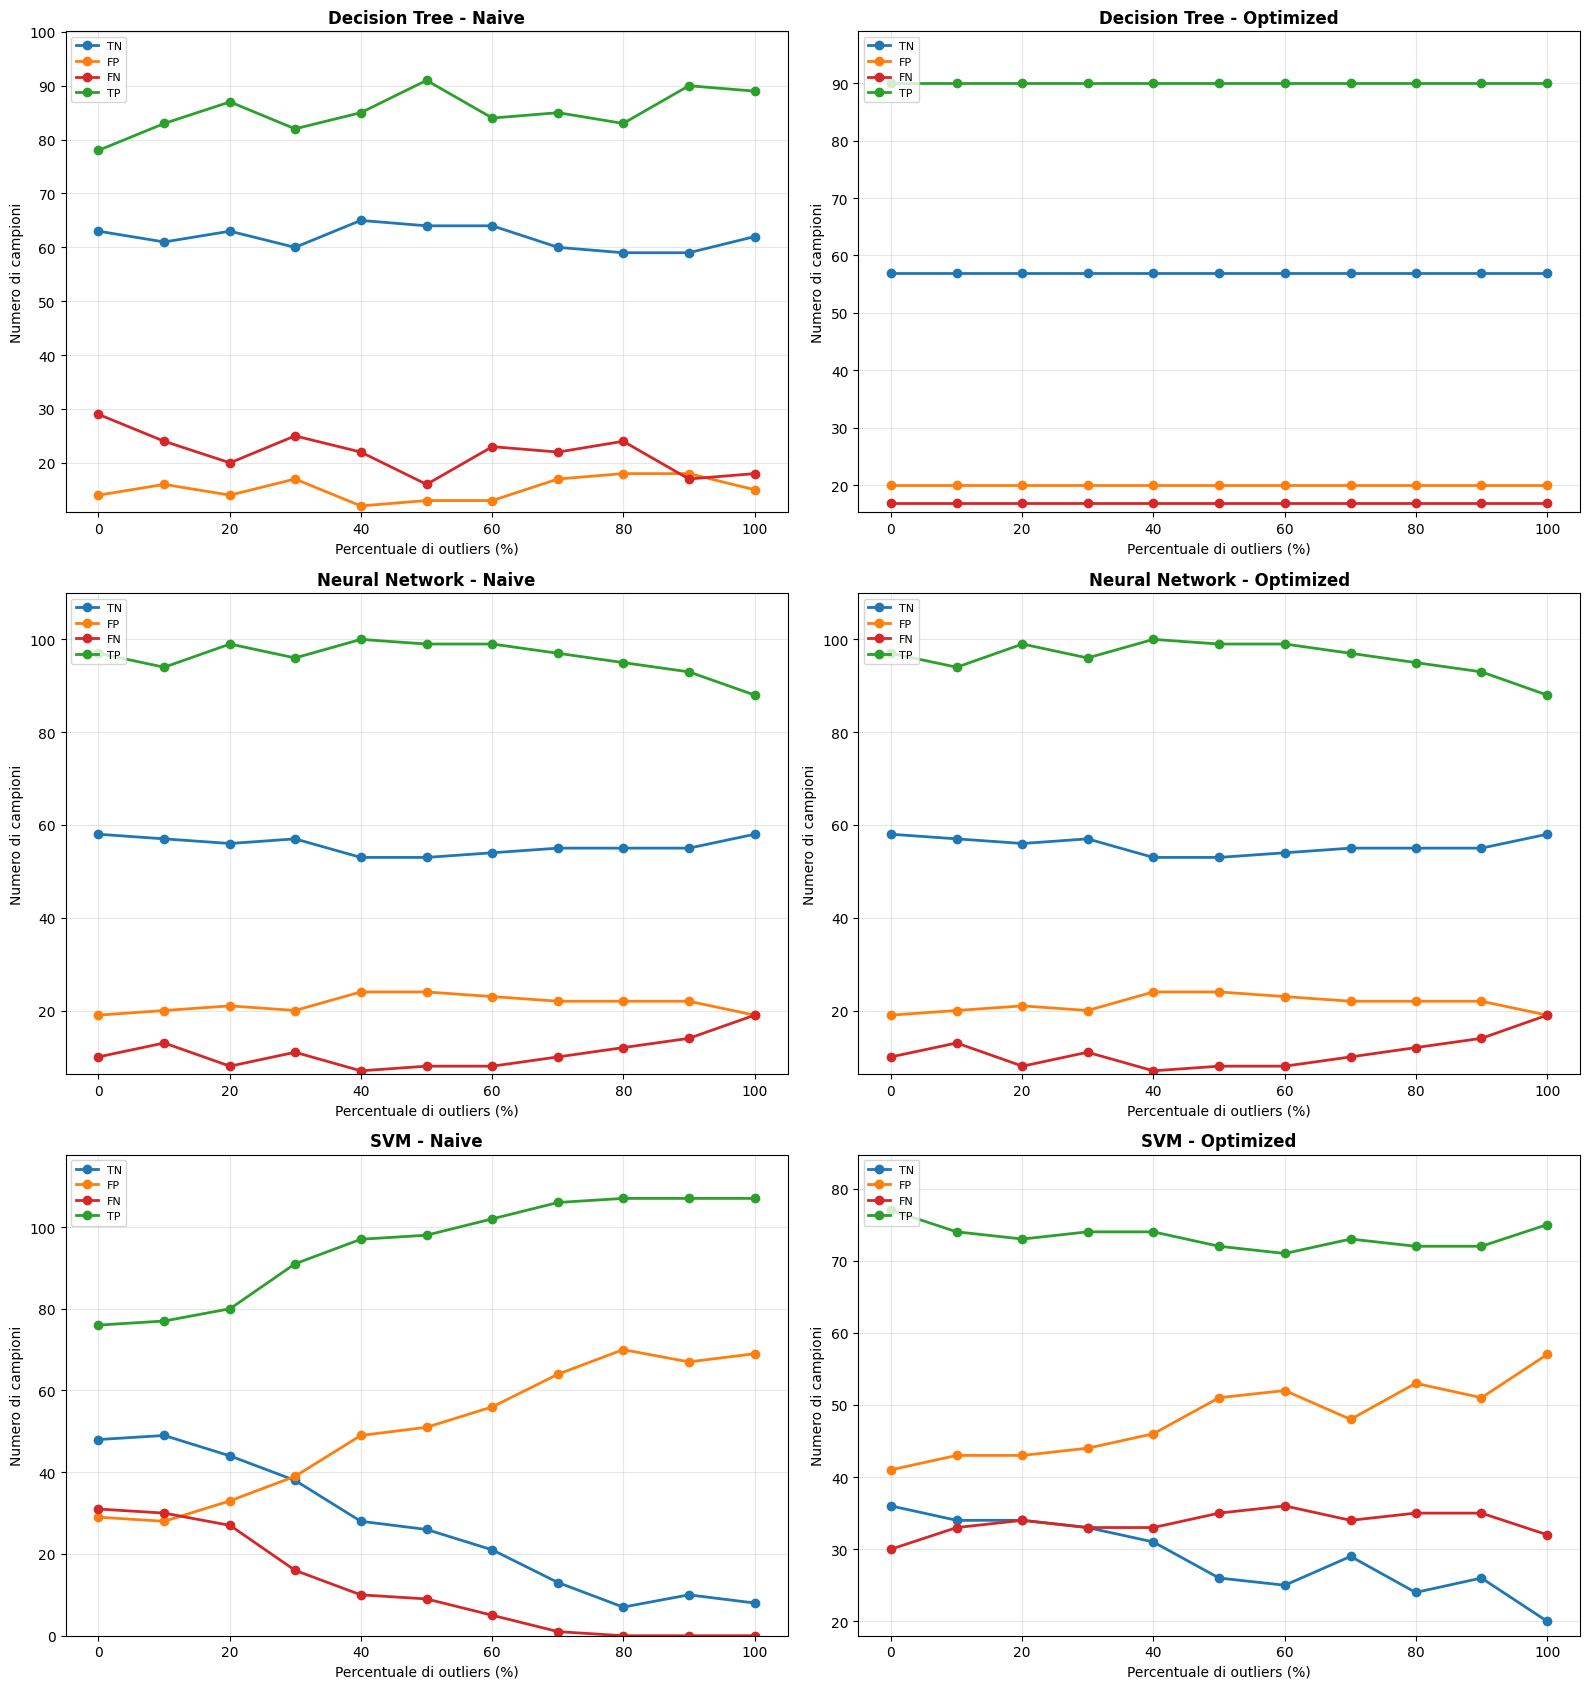

In [61]:
def plot_confusion_matrix_grid(confusion_matrix_values, contamination_history=None):
    """
    Crea una griglia di grafici 2 colonne x N righe (Naive | Optimized per modello)
    
    Parameters:
    -----------
    confusion_matrix_values : dict
        Dizionario con i valori delle confusion matrix
    contamination_history : list, optional
        Storia della contaminazione con step e actual_rate (default: usa step numerici)
    """
    
    # Estrai tutti i modelli unici (DT, SVM, NN)
    models = sorted(set(key.split(' - ')[0] for key in confusion_matrix_values.keys()))
    
    # Setup subplot: 2 colonne (Naive, Optimized), righe = numero modelli
    fig, axes = plt.subplots(len(models), 2, figsize=(16, 17))
    
    # Se c'è solo un modello, axes diventa 1D → forzo 2D
    if len(models) == 1:
        axes = [axes]
    
    colors = {
        'TN': '#1f77b4',  # blu
        'FP': '#ff7f0e',  # arancione  
        'FN': '#d62728',  # rosso
        'TP': '#2ca02c'   # verde
    }
    
    for model_idx, model in enumerate(models):
        for col_idx, approach in enumerate(["Naive", "Optimized"]):
            ax = axes[model_idx][col_idx]
            
            # Trova la chiave corretta (es: "Decision Tree - Naive")
            model_key = f"{model} - {approach}"
            if model_key not in confusion_matrix_values:
                continue
            
            # Estrai gli step
            steps = sorted(confusion_matrix_values[model_key].keys())
            
            if contamination_history is None:
                x_values = steps
                x_label = "Step"
            else:
                # mapping step -> contamination_rate
                contam_dict = {h['step']: h['actual_rate'] for h in contamination_history}
                if 0 not in contam_dict:
                    contam_dict[0] = 0.0
                x_values = [contam_dict.get(step, 0) * 100 for step in steps]
                x_label = "Percentuale di outliers (%)"
            
            # Estrai valori TN, FP, FN, TP
            metrics_data = {
                'TN': [confusion_matrix_values[model_key][step]['TN'] for step in steps],
                'FP': [confusion_matrix_values[model_key][step]['FP'] for step in steps],
                'FN': [confusion_matrix_values[model_key][step]['FN'] for step in steps],
                'TP': [confusion_matrix_values[model_key][step]['TP'] for step in steps]
            }
            
            # Plot linee
            for metric in ['TN', 'FP', 'FN', 'TP']:
                ax.plot(x_values, metrics_data[metric], 
                        color=colors[metric], 
                        marker='o',
                        linestyle='-',
                        label=metric,
                        linewidth=2,
                        markersize=6)
            
            # Personalizza subplot
            ax.set_title(f"{model} - {approach}", fontsize=12, fontweight='bold')
            ax.set_xlabel(x_label, fontsize=10)
            ax.set_ylabel("Numero di campioni", fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8, loc='upper left')
            
            # Limiti Y dinamici
            all_values = [v for metric in metrics_data.values() for v in metric]
            ax.set_ylim(min(all_values) * 0.9, max(all_values) * 1.1)
    
    plt.tight_layout()
    plt.show()

# Usa la funzione corretta
plot_confusion_matrix_grid(confusion_matrix_values, contamination_history)

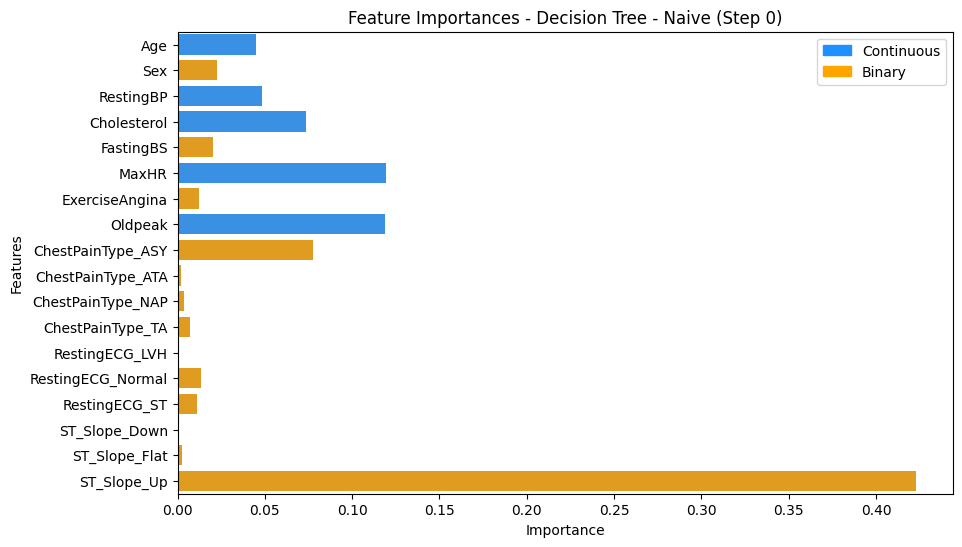

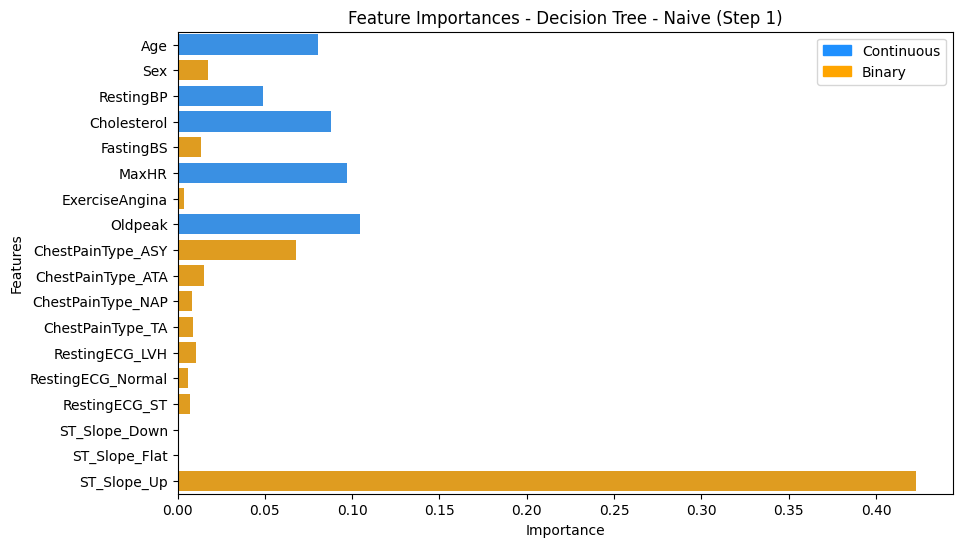

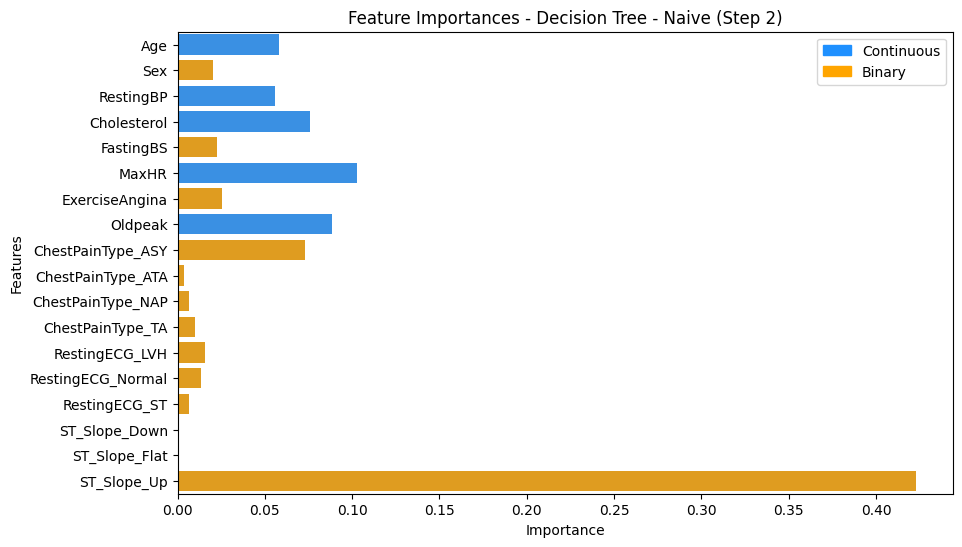

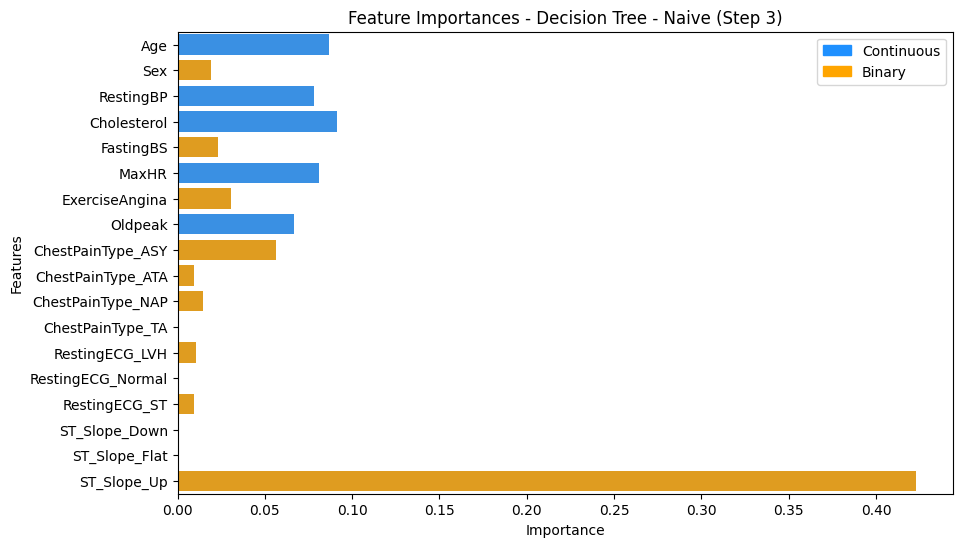

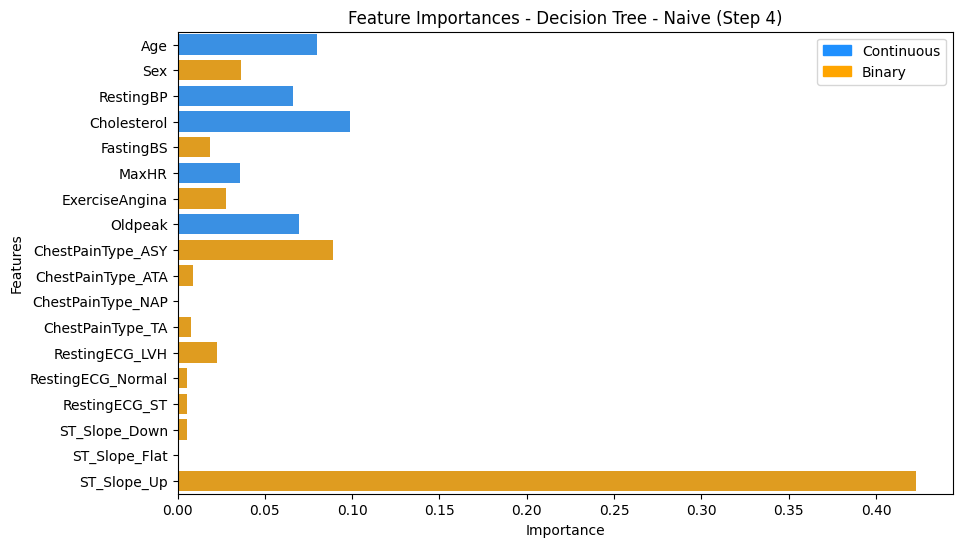

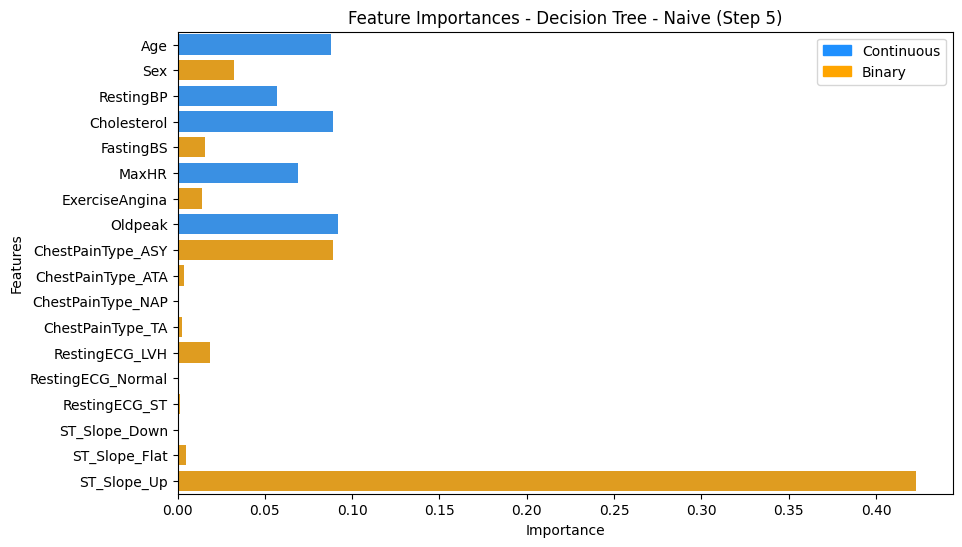

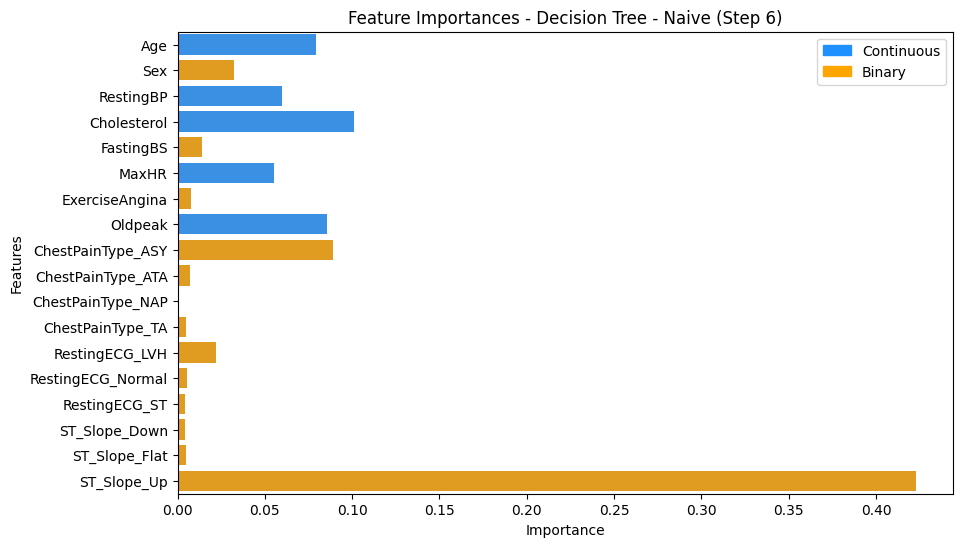

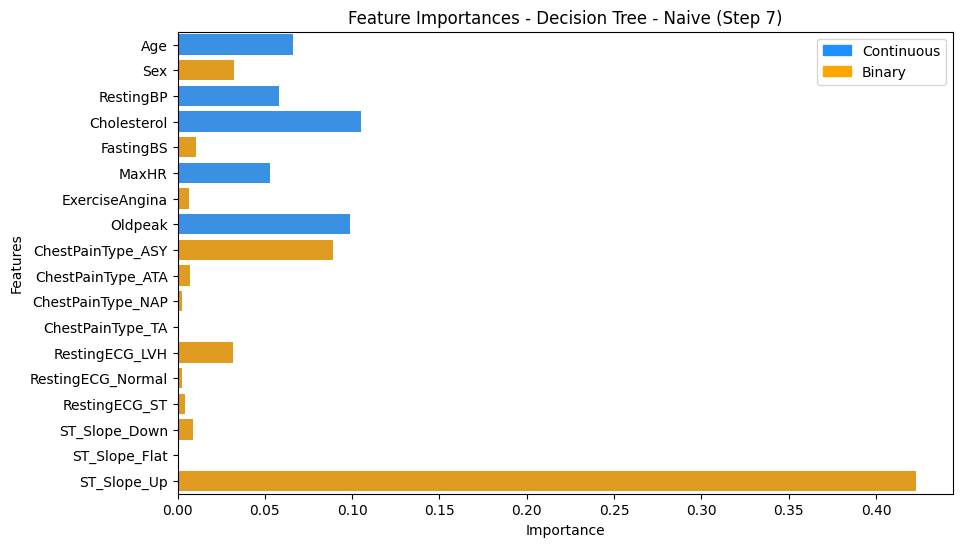

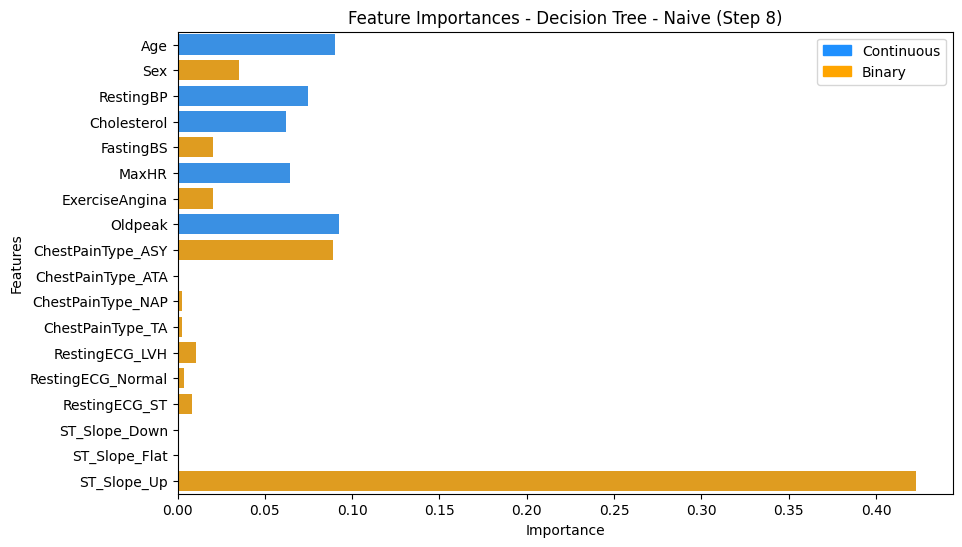

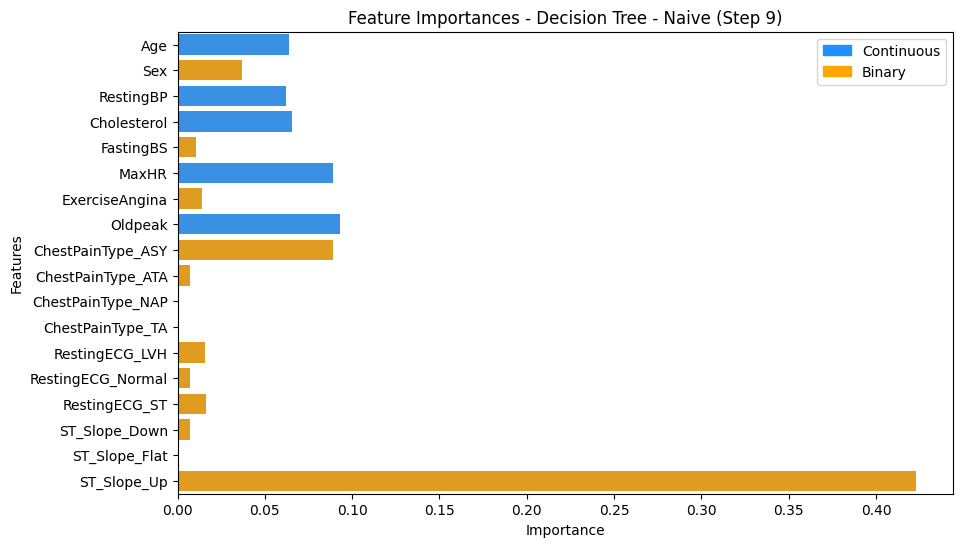

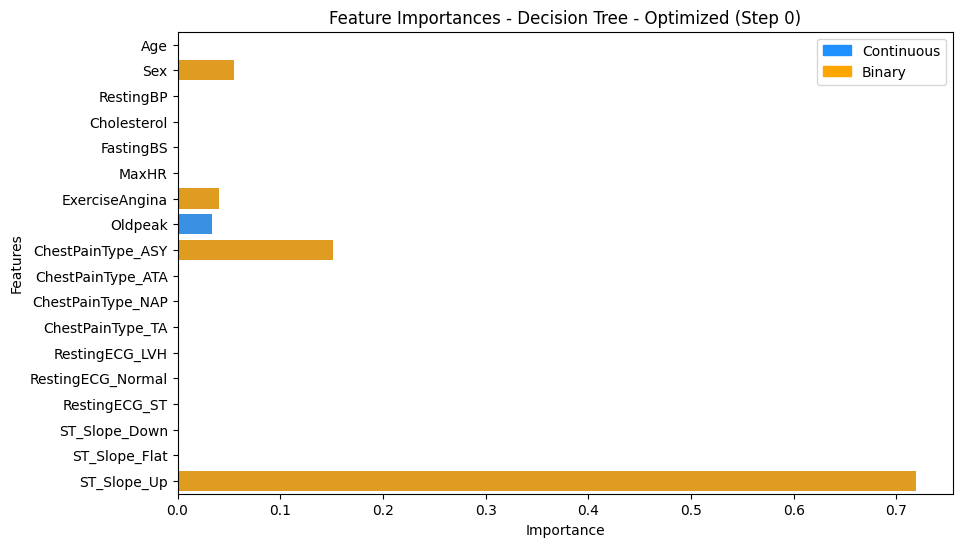

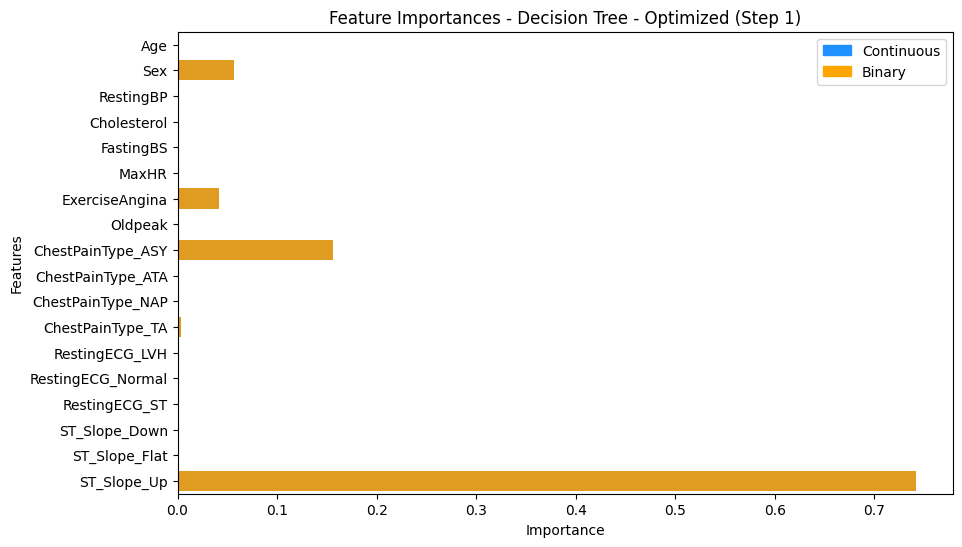

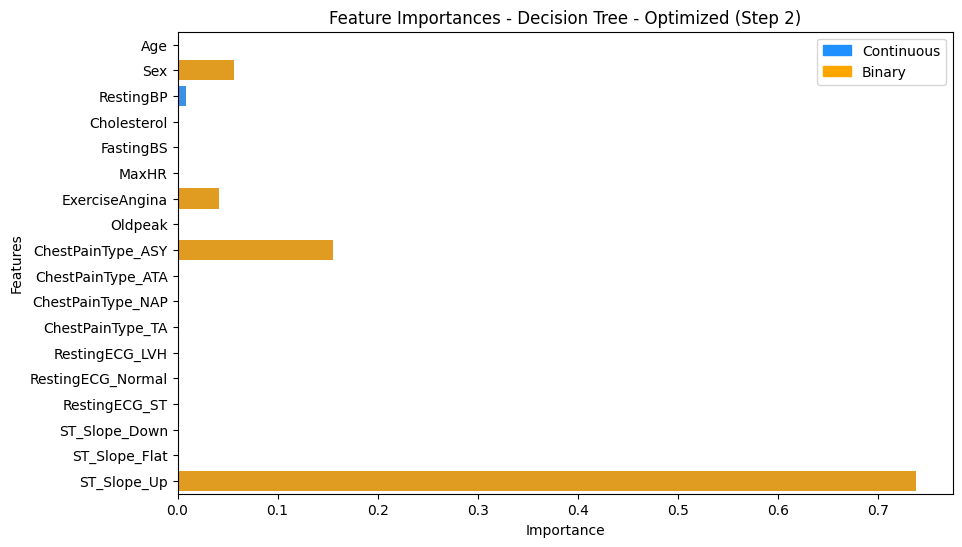

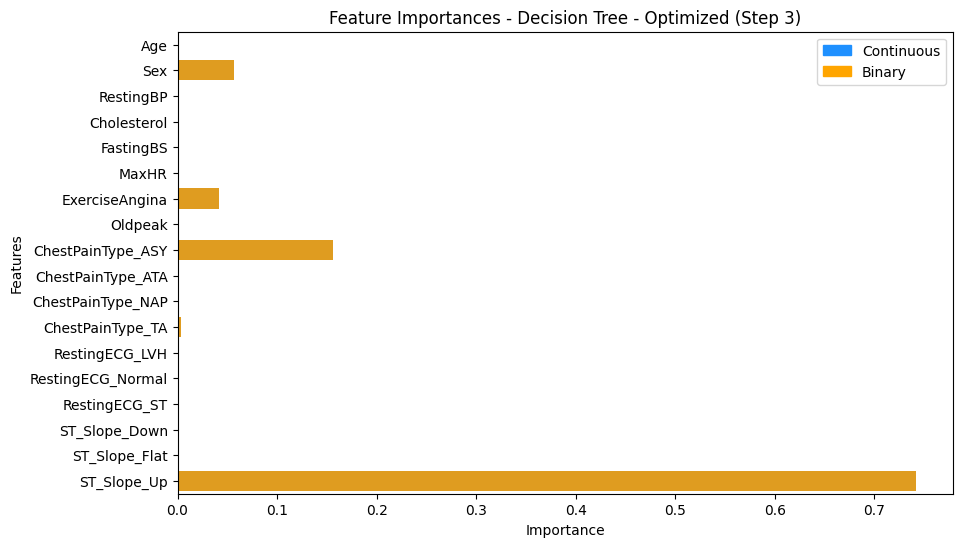

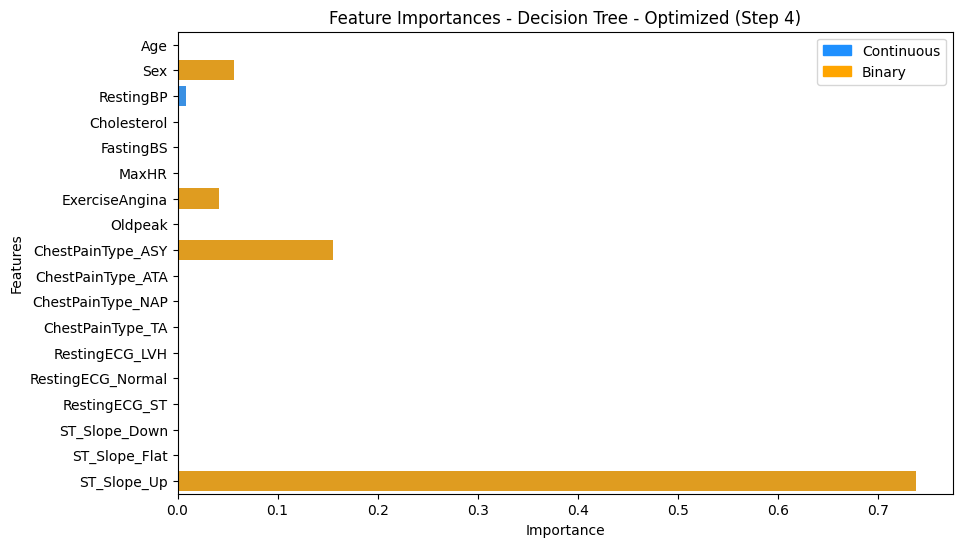

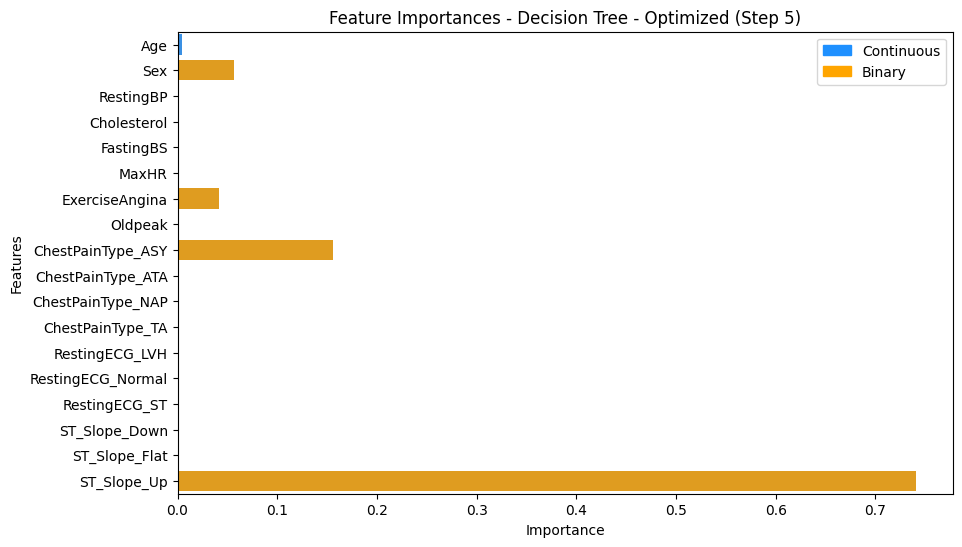

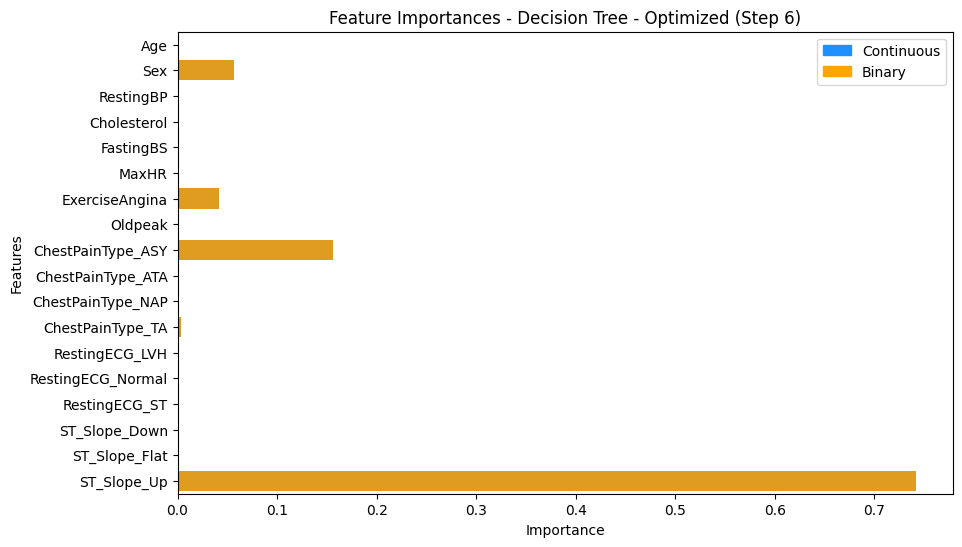

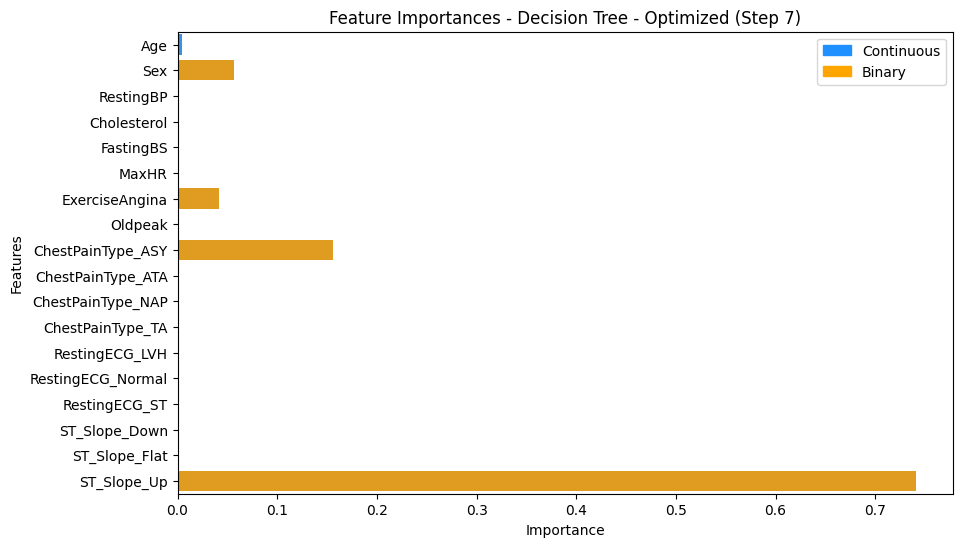

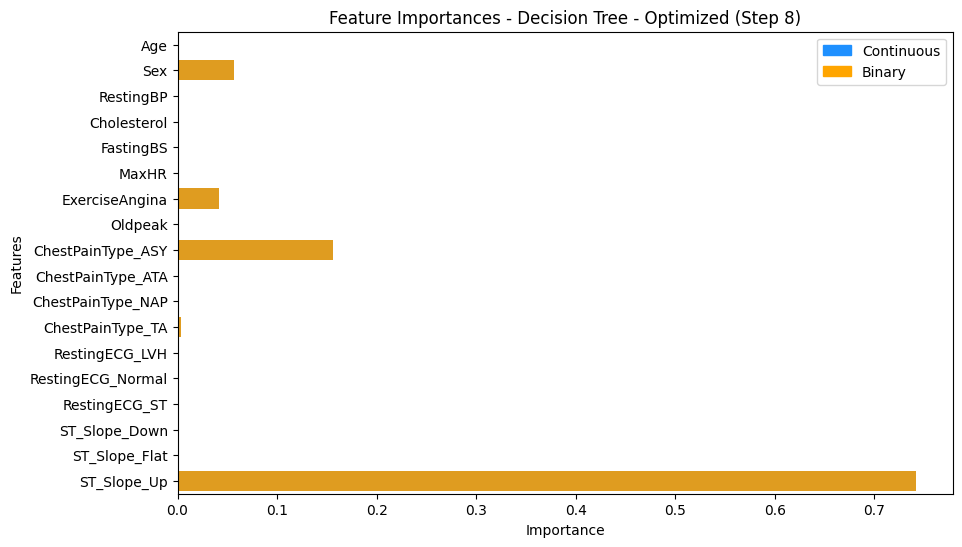

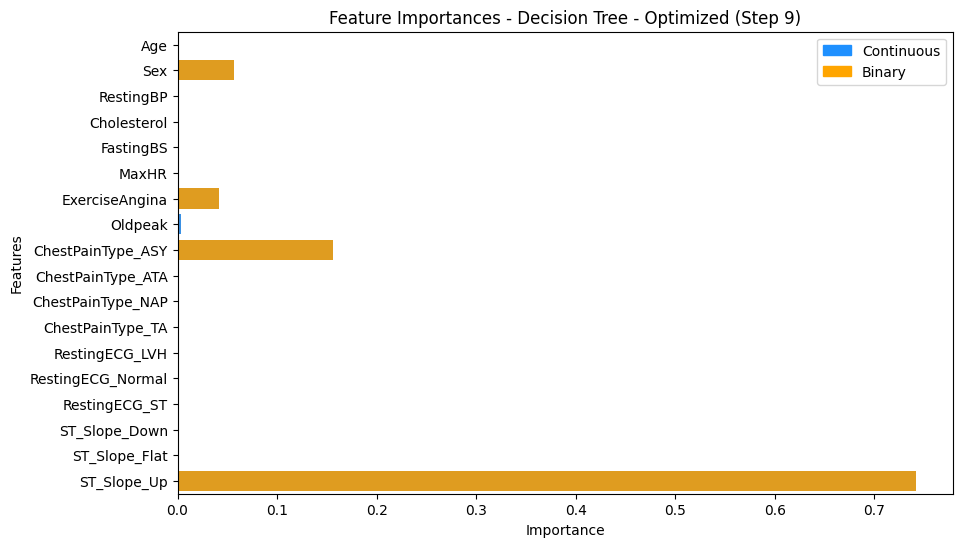

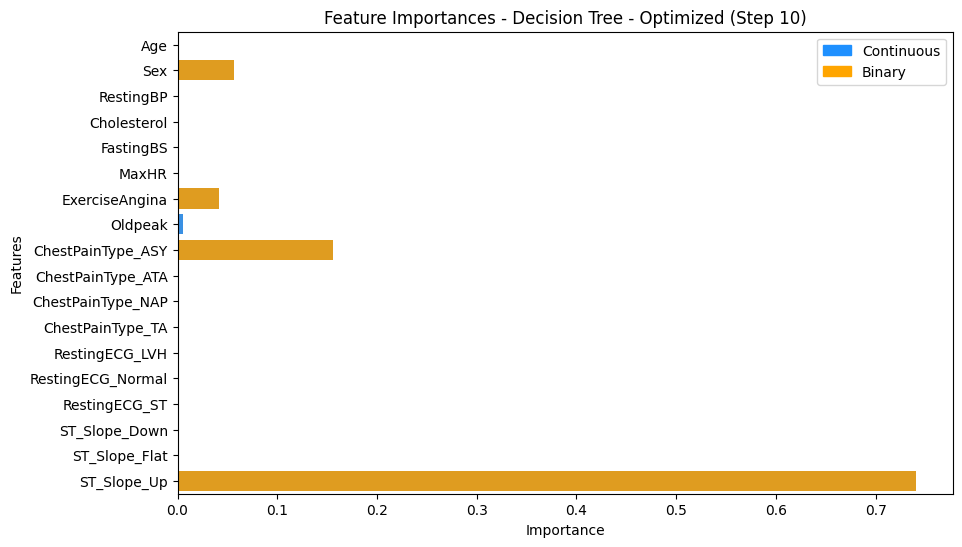

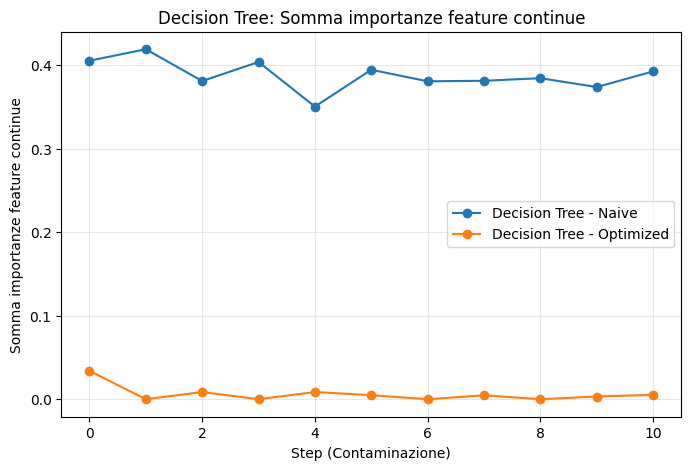

'\nplt.figure(figsize=(8, 5))\nfor key in feature_importances:\n    if "SVM" in key:\n        steps = []\n        sum_importances = []\n        for step, importances in feature_importances[key].items():\n            sum_continuous = sum(\n                imp for imp, feat in zip(importances, X_original.columns)\n                if feat in continuous_features\n            )\n            steps.append(step)\n            sum_importances.append(sum_continuous)\n        plt.plot(steps, sum_importances, marker=\'o\', label=key)\nplt.xlabel("Step (Contaminazione)")\nplt.ylabel("Somma importanze feature continue")\nplt.title("SVM: Somma importanze feature continue")\nplt.legend()\nplt.grid(True, alpha=0.3)\nplt.show()\n'

In [ ]:
import matplotlib.patches as mpatches

for key in feature_importances:
    for step, importances in feature_importances[key].items():
        plt.figure(figsize=(10, 6))
        feature_names = list(X_original.columns)
        colors = ['dodgerblue' if feat in continuous_features else 'orange' for feat in feature_names]
        sns.barplot(x=importances, y=feature_names, palette=colors)
        # Il titolo ora mostra modello e approccio
        plt.title(f"Feature Importances - {key} (Step {step})")
        plt.xlabel("Importance")
        plt.ylabel("Features")
        blue_patch = mpatches.Patch(color='dodgerblue', label='Continuous')
        orange_patch = mpatches.Patch(color='orange', label='Binary')
        plt.legend(handles=[blue_patch, orange_patch])
        plt.show()

# Calcola la somma delle importanze delle feature continue per ogni step e approccio
# --- Decision Tree ---
plt.figure(figsize=(8, 5))
for key in feature_importances:
    if "Decision Tree" in key:
        steps = []
        sum_importances = []
        for step, importances in feature_importances[key].items():
            sum_continuous = sum(
                imp for imp, feat in zip(importances, X_original.columns)
                if feat in continuous_features
            )
            steps.append(step)
            sum_importances.append(sum_continuous)
        plt.plot(steps, sum_importances, marker='o', label=key)
plt.xlabel("Step (Contaminazione)")
plt.ylabel("Somma importanze feature continue")
plt.title("Decision Tree: Somma importanze feature continue")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- SVM ---
'''
plt.figure(figsize=(8, 5))
for key in feature_importances:
    if "SVM" in key:
        steps = []
        sum_importances = []
        for step, importances in feature_importances[key].items():
            sum_continuous = sum(
                imp for imp, feat in zip(importances, X_original.columns)
                if feat in continuous_features
            )
            steps.append(step)
            sum_importances.append(sum_continuous)
        plt.plot(steps, sum_importances, marker='o', label=key)
plt.xlabel("Step (Contaminazione)")
plt.ylabel("Somma importanze feature continue")
plt.title("SVM: Somma importanze feature continue")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
'''

=== ANALISI DELL'IMPATTO DELLE FEATURE ===



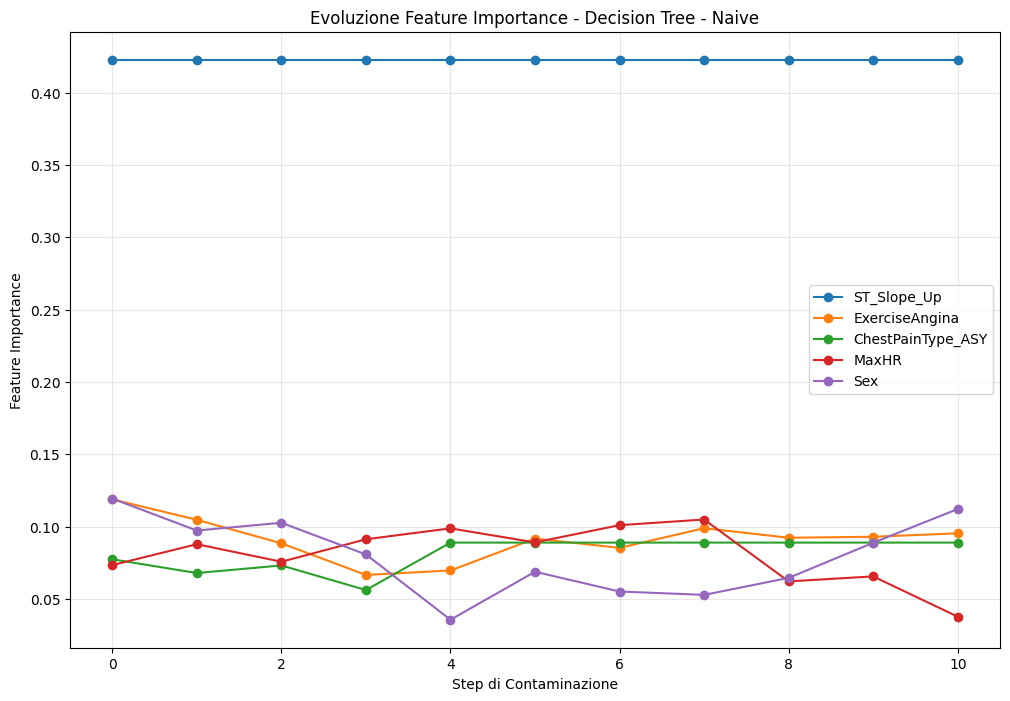


Decision Tree - Naive:
Media importanza feature continue: 0.0525
Media importanza feature binarie: 0.0567


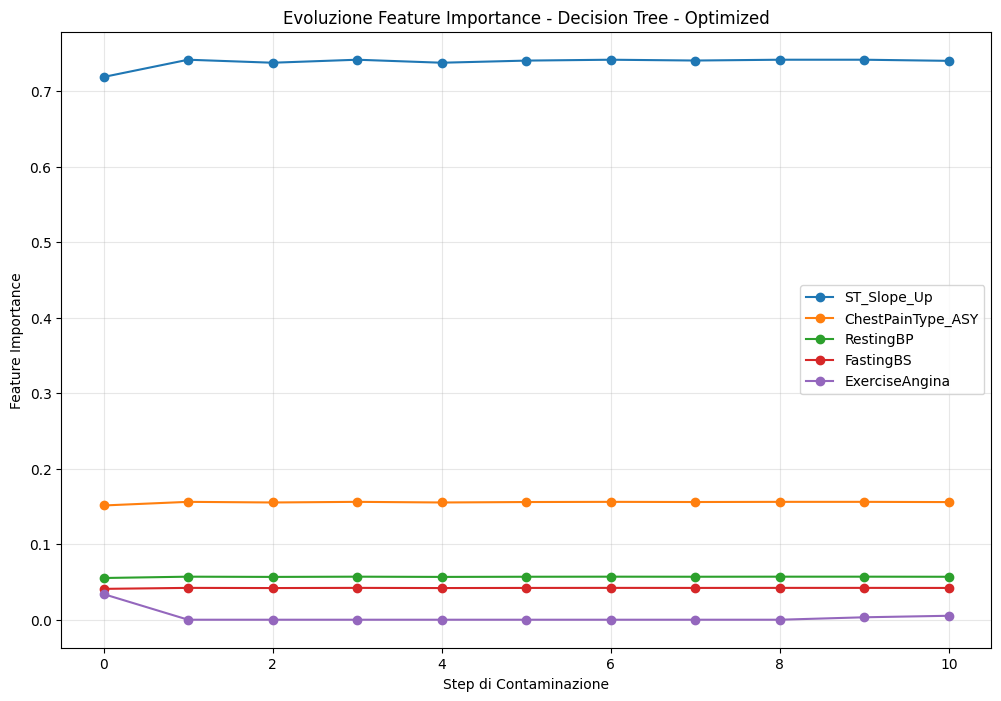


Decision Tree - Optimized:
Media importanza feature continue: 0.0118
Media importanza feature binarie: 0.0724


In [ ]:
# %%
# ANALISI AGGIUNTIVE PER IL PROGETTO MISSING VALUES

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

'''
# %%
# 4. ANALISI ROC E CALIBRAZIONE
def roc_calibration_analysis(all_metrics_duplicates, duplicated_dfs, X_test_clean, y_test_clean):
    """
    Analisi delle curve ROC e della calibrazione dei modelli
    """
    print("=== ANALISI ROC E CALIBRAZIONE ===\n")
    
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.svm import SVC
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.impute import SimpleImputer
    from sklearn.calibration import CalibratedClassifierCV
    
    # Testa su alcuni step rappresentativi
    test_steps = [0.1, 0.3, 0.5]
    models_config = {
        'Decision Tree': DecisionTreeClassifier(),
        'SVM': SVC(probability=True),
        'Neural Network': MLPClassifier(max_iter=1000)
    }
    
    fig, axes = plt.subplots(len(test_steps), 3, figsize=(18, 6*len(test_steps)))
    if len(test_steps) == 1:
        axes = axes.reshape(1, -1)
    
    roc_results = []
    
    for step_idx, perc in enumerate(test_steps):
        if perc not in duplicated_dfs:
            continue

        df_degraded = duplicated_dfs[perc]
        X_contaminated = df_degraded.drop('HeartDisease', axis=1)
        y_contaminated = df_degraded['HeartDisease']
        
        X_train, _, y_train, _ = train_test_split(
            X_contaminated, y_contaminated, test_size=0.2, random_state=42
        )
        
        imputer = SimpleImputer(strategy='mean')
        X_train_imp = imputer.fit_transform(X_train)
        X_test_imp = imputer.transform(X_test_clean)
        
        for model_idx, (model_name, model) in enumerate(models_config.items()):
            model.fit(X_train_imp, y_train)
            
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test_imp)[:, 1]
            else:
                y_proba = model.decision_function(X_test_imp)
            
            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test_clean, y_proba)
            auc_score = roc_auc_score(y_test_clean, y_proba)
            
            axes[step_idx, model_idx].plot(fpr, tpr, label=f'ROC (AUC={auc_score:.3f})')
            axes[step_idx, model_idx].plot([0, 1], [0, 1], 'k--', alpha=0.5)
            axes[step_idx, model_idx].set_xlabel('False Positive Rate')
            axes[step_idx, model_idx].set_ylabel('True Positive Rate')
            axes[step_idx, model_idx].set_title(f'{model_name} - {int(perc*100)}% Missing')
            axes[step_idx, model_idx].legend()
            axes[step_idx, model_idx].grid(True, alpha=0.3)
            
            roc_results.append({
                'model': model_name,
                'missing_perc': perc,
                'auc_score': auc_score
            })
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(roc_results)

'''

# %%
# 5. ANALISI DELL'IMPATTO SPECIFICO DELLE FEATURE
def feature_impact_analysis(feature_importances, continuous_features, binary_features):
    """
    Analizza come l'importanza delle feature cambia con l'aumento dei missing values
    """

    # Rimuovi la target dalle liste se presente
    continuous_features = [f for f in continuous_features if f != 'HeartDisease']
    binary_features = [f for f in binary_features if f != 'HeartDisease']

    print("=== ANALISI DELL'IMPATTO DELLE FEATURE ===\n")
    
    if not feature_importances:
        print("Nessuna feature importance disponibile")
        return
    
    # Solo per Decision Tree che ha feature_importances
    for model_approach, step_importances in feature_importances.items():
        if 'Decision Tree' not in model_approach:
            continue
            
        # Crea DataFrame delle importanze per step
        importance_data = []
        for step, importances in step_importances.items():
            # Verifica che importances sia un array/lista valida
            if importances is not None and len(importances) > 0:
                for feat_idx, importance in enumerate(importances):
                    importance_data.append({
                        'step': step,
                        'feature_idx': feat_idx,
                        'importance': importance
                    })
        
        if not importance_data:
            continue
            
        importance_df = pd.DataFrame(importance_data)
        
        # Visualizza l'evoluzione delle top 5 feature più importanti
        plt.figure(figsize=(12, 8))
        
        # Trova le top feature basate sull'importanza media
        avg_importance = importance_df.groupby('feature_idx')['importance'].mean().sort_values(ascending=False)
        top_features = avg_importance.head(5).index
        
        for feat_idx in top_features:
            feat_data = importance_df[importance_df['feature_idx'] == feat_idx].sort_values('step')
            # Ottieni il nome della feature corrispondente all'indice
            if feat_idx < len(continuous_features):
                feat_name = continuous_features[feat_idx]
            elif feat_idx < len(continuous_features) + len(binary_features):
                feat_name = binary_features[feat_idx - len(continuous_features)]
            else:
                feat_name = f"Feature {feat_idx}"
            plt.plot(feat_data['step'], feat_data['importance'], 
                    marker='o', label=feat_name)
        
        plt.xlabel('Step di Contaminazione')
        plt.ylabel('Feature Importance')
        plt.title(f'Evoluzione Feature Importance - {model_approach}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Analisi separata per feature continue vs binarie (se hai i nomi delle feature)
        print(f"\n{model_approach}:")
        
        # Verifica che gli indici esistano prima di accedervi
        continuous_indices = [i for i in range(len(continuous_features)) if i in avg_importance.index]
        binary_start = len(continuous_features)
        binary_end = len(continuous_features) + len(binary_features)
        binary_indices = [i for i in range(binary_start, binary_end) if i in avg_importance.index]
        
        if continuous_indices:
            print(f"Media importanza feature continue: {avg_importance[continuous_indices].mean():.4f}")
        else:
            print("Nessuna feature continua trovata negli indici")
            
        if binary_indices:
            print(f"Media importanza feature binarie: {avg_importance[binary_indices].mean():.4f}")
        else:
            print("Nessuna feature binaria trovata negli indici")


# Esegui l'analisi comprehensive:
comprehensive_results = feature_impact_analysis(
    feature_importances, continuous_features, binary_features
)

In [ ]:
df_results = pd.DataFrame(mutua_informazione_feature)
print(df_results)

plt.figure(figsize=(10, 6))
plt.plot(df_results["perc_outliers"]*100, df_results["MI_numerical"], marker='o', label="MI Continuous")
plt.plot(df_results["perc_outliers"]*100, df_results["MI_binary"], marker='s', label="MI Binary")
plt.xlabel("Percentuale di outliers nel dataset (%)")
plt.ylabel("Mutual Information media")
plt.title("Andamento della Mutual Information media vs percentuale di outliers")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

   MI_numerical  MI_binary  perc_outliers
0      0.073044   0.105932            0.1
1      0.070161   0.105932            0.2
2      0.067430   0.105932            0.3
3      0.061252   0.105932            0.4
4      0.062887   0.105932            0.5
5      0.060463   0.105932            0.6
6      0.056921   0.105932            0.7
7      0.050448   0.105932            0.8
8      0.051412   0.105932            0.9
9      0.055446   0.105932            1.0
